# PlantSpycies

The goal of the project is to produce a plant species and disease recognition method based on leaf images.

## Libraries

In [ ]:

from sklearn.preprocessing import StandardScaler # standardize features by removing the mean and scaling to unit variance
import matplotlib.pyplot as plt  # plotting images

import numpy as np  # numerical computing 
import pandas as pd  # data structures and data analysis tools

import PIL # Python Imaging Library. Opening, manipulating, and saving images
import cv2 # OpenCV computer vision. Similar to PIL not used because cv2.show() makes Jupyter Notebooks crash in Collab

import os # accessing directory structure
import shutil # operations on files and folders
import pathlib # exploring files and folders and its properties
from pathlib import Path # creates paths from strings
import glob # takes a wildcard and returns the path of all files and directories matching the wildcard
from google.colab import drive # connection to Google Drive

import tensorflow as tf # deep neural networks
from tensorflow import keras # interface for TensorFlow
from tensorflow.keras import layers # tensor-in tensor-out computation functions
from tensorflow.keras.layers.experimental.preprocessing import Rescaling # rescales input values to a new range
from tensorflow.keras.models import Sequential # linear stack of layers
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout # core layers; reshaping; regularization
from tensorflow.keras.layers import Conv2D, MaxPooling2D # convolution and pooling
from tensorflow.keras import regularizers, optimizers # apply penalties on layer parameters; argument for compiling model
from tensorflow.python.keras.models import load_model # to load a saved model
from skimage.transform import resize # change images shape

from tensorflow.keras.applications.resnet50 import ResNet50 # model for transfer learning
from tensorflow.keras.applications.vgg16 import VGG16 # model for transfer learning
from tensorflow.keras.layers import GlobalAveragePooling2D # global average pooling operation for spatial data

import sklearn # machine learning tools
from sklearn import metrics # performance metrics
from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Custom functions for analysis

*   "graph" function plots 2 figures :  
  1.   train loss and val_loss vs. epoch, supperposed in the same plot
  2.   train accuracy and val accuracy vs. epoch, supperposed in the same plot.


*   The "conf_matrix" function plots itself on the train set.
*   The "classif_report" function makes a classification report given a model and a dataset.



In [ ]:
### graph ###
def graph(model_history, complement_to_title = "", accuracy_scale ="0"):

  # We get the losses and accuracies from model_history
  train_loss = model_history.history["loss"]
  val_loss = model_history.history["val_loss"]
  train_acc = model_history.history["accuracy"]
  val_acc = model_history.history["val_accuracy"]

  # We'll plot 2 charts in a row, so we create an horizontal rectancular figure
  plt.figure(figsize = (20, 8))

  plt.subplot(121) # 1st figure from a matrix of 1 row and 2 columns
  plt.plot(train_loss)
  plt.plot(val_loss)
  plt.title('Model Loss per epoch\n'+complement_to_title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'val'], loc='right')

  plt.subplot(122) # 2nd figure from a matrix of 1 row and 2 columns
  plt.plot(train_acc)
  plt.plot(val_acc)
  if accuracy_scale != 0:
    plt.ylim(0,1.1)
  plt.title('Model Accuracy per epoch\n'+complement_to_title)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'val'], loc='right')
  plt.show()


### conf_matrix ###
def conf_matrix(labels, predictions, num_class):

  plt.figure(figsize= (20,5))

  cm = confusion_matrix(labels, predictions)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(range(num_class)))
  
  fig, ax = plt.subplots(figsize=(15,15))
  disp.plot(ax=ax,colorbar= False,cmap = 'YlGnBu')
  plt.title("Confusion Matrix")
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.show()


### classif_report ###
def classif_report(labels,predictions, model_history=None):
  """
  When dealing with a loaded model there is no history,
  so the function should receive only the first two parameters 
  """
  print(classification_report(labels, predictions, digits=3))

  # Print model performance values with 1 decimal place
  if model_history :
    print("Train Accuracy  : {:.1f} %".format(model_history.history['accuracy'][-1]*100))

  print("Test Accuracy   : {:.1f} %".format(accuracy_score(labels, predictions) * 100))
  print("Precision Score : {:.1f} %".format(precision_score(labels, predictions, average='micro') * 100))
  print("Recall Score    : {:.1f} %".format(recall_score(labels, predictions, average='micro') * 100))

## Paths for Data input and output

In [ ]:
print('Current working directory:', os.getcwd()) # gets current working directory

Current working directory: /content


Our dataset is importing from a Google Drive

In [ ]:
# Mount contents in our Google Drive
drive.mount('/content/gdrive/')

######Drive mai22.bds.plant.recognition

# Create paths from directories strings for the REDUCED data set
data_dir_train_min = "gdrive/My Drive/New Plant Diseases/New Plant Diseases Dataset/New Plant Diseases Dataset/train_min"
data_dir_train_min = pathlib.Path(data_dir_train_min)

data_dir_test_min = "gdrive/My Drive/New Plant Diseases/New Plant Diseases Dataset/New Plant Diseases Dataset/test_min"
data_dir_test_min = pathlib.Path(data_dir_test_min)


# Create paths from directories strings for the FULL data set
data_dir_train_full = "gdrive/My Drive/New Plant Diseases/New Plant Diseases Dataset/New Plant Diseases Dataset/train"
data_dir_train_full = pathlib.Path(data_dir_train_full)

data_dir_test_full = "gdrive/My Drive/New Plant Diseases/New Plant Diseases Dataset/New Plant Diseases Dataset/test"
data_dir_test_full = pathlib.Path(data_dir_test_full)

# Directories for saving the models
model_save_dir = 'gdrive/My Drive/New Plant Diseases/Modèles/'
#model_save_dir= pathlib.Path(model_save_dir)

# checkpoint_filepath (where models are saved)
checkpoint_filepath = 'gdrive/My Drive/New Plant Diseases/checkpoints'

Mounted at /content/gdrive/


## Creation of a reduced Dataset (Train and Test) to be used for testing the code

In [ ]:
#Here we create one time two new folders train_min and test_min
# train_min
dir_train_min = "gdrive/My Drive/New Plant Diseases/New Plant Diseases Dataset/New Plant Diseases Dataset/train_min"
for dir in os.listdir(data_dir_train_full): # for every subfolder name in the original dataset
    dir2 = os.path.join(dir_train_min, dir) # in each iteration, we add each subfolder name (same name as the original dataset)
    if not os.path.exists(dir2): # if it does not already exist
      os.makedirs(dir2) # create the new directory
    
      src = pathlib.Path((os.path.join(data_dir_train_full, dir))) # we define the source directory (the corresponding dir from the original dataset)
      count = 0
      for e in ['*.JPG', '*.jpg']: # we use any extension (capital letters or lower)
        for filename in src.glob(e): # for all files with those extensions  
          if count < 200: # up to 200 files
            shutil.copy(filename, dir2) # we copy each file to the "min" directory
            count += 1
          else:
           break


# test_min (same procedure and comments as train_min but creating 50 images per category folder)
dir_test_min = "gdrive/My Drive/New Plant Diseases/New Plant Diseases Dataset/New Plant Diseases Dataset/test_min"
for dir in os.listdir(data_dir_test_full):
    dir2 = os.path.join(dir_test_min, dir)
    if not os.path.exists(dir2):
      os.makedirs(dir2)
    
      src = pathlib.Path((os.path.join(data_dir_test_full, dir)))
      count = 0
      for e in ['*.JPG', '*.jpg']:
        for filename in src.glob(e):
          if count < 50:
            shutil.copy(filename, dir2)
            count += 1
          else:
            break

## Choice of the Dataset: we choose the full dataset to explore data

In [ ]:
### Choice of dataset for running the models ###

# Variable 'dataset' = "reduced" (no case sensitive) --> Reduced Dataset
# Otherwise --> Reduced Dataset

# We choose the full dataset to explore data:
dataset = "NOTreduced"

if dataset.lower() == "reduced":
  # Reduced Dataset
  data_dir_train = data_dir_train_min
  data_dir_test = data_dir_test_min
else:
  # Full Dataset
  data_dir_train = data_dir_train_full
  data_dir_test = data_dir_test_full

### Definition of Train and Test sets

In [ ]:
# Definition of batch size: number of samples passed through to the network at a time (batches passed in each epoch = training set size / batch_size)
# large batch size => quicker completion of each epoch during training
# BUT : model may degrade with larger batch size and may be unable to generalize well on data it hasn't seen before
# batch size => hyperparameter to be tuned depending on model performance during training
batch_size =  128   

# Images size set to the original value (256 x 256)
img_height = 256 
img_width = 256

# Generation of train tf.data.Dataset from image files in train directory
train_ds_data_analysis = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  label_mode = 'int', # labels are encoded as integers (for sparse_categorical_crossentropy loss)
  # labels = 'inferred' by default => labels are generated from the directory structure
  image_size=(img_height, img_width),
  batch_size=batch_size)
  # shuffle=False) # Whether to shuffle the data. Default: True. 
  # If set to False, sorts the data in alphanumeric order, needed afterwards to be sure to show all classes in subplots

# Generation of test tf.data.Dataset from image files in train directory
test_ds_data_analysis = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  label_mode = 'int', # labels are encoded as integers (for sparse_categorical_crossentropy loss)
  image_size=(img_height, img_width),
  batch_size=batch_size)
  # shuffle=False) # Whether to shuffle the data. Default: True. 
  # If set to False, sorts the data in alphanumeric order, needed afterwards to be sure to show all classes in subplots

#rescale = Rescaling(scale=1.0/255)
#train_gen = train_ds.map(lambda image,label:(rescale(image),label))
#test_gen = test_ds.map(lambda image,label:(rescale(image),label))

Found 70295 files belonging to 38 classes.
Found 17571 files belonging to 38 classes.


## Exploratory Data Analysis

### Total numbers of leaves in the Train and Test folder

In [ ]:
# The total number of leaf images is calculated with the length of the list of all files in the different folders
# using glob module, that takes a wildcard (all folder names and all file names => */*) and returns the path of all files
# and directories matching the wildcard for both .JPG and .jpg extension files
image_count_train = len(list(data_dir_train.glob('*/*.JPG')))+len(list(data_dir_train.glob('*/*.jpg')))
image_count_test = len(list(data_dir_test.glob('*/*.JPG')))+len(list(data_dir_test.glob('*/*.jpg')))
print('Images in the Train folder :', image_count_train)
print('Images in the Test folder :', image_count_test)


Images in the Train folder : 70295
Images in the Test folder : 17571


Here some examples of leaf pictures.

(256, 256)
('R', 'G', 'B')


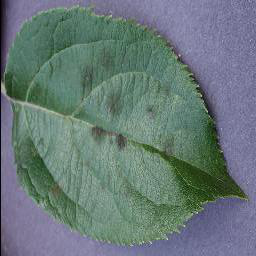

In [ ]:
# List of apple image files on one of the folders, 'Apple___Apple_scab' for example
apple_leafs = list(data_dir_train.glob('Apple___Apple_scab/*'))

# Open one of the files on the list, the 3rd one for example (index [2] from the list)
apple = PIL.Image.open(str(apple_leafs[2]))

# Image size
print(apple.size)
# get layers (bands) from images
print(apple.getbands())
# Show image
apple



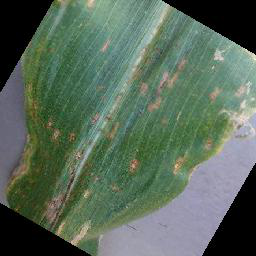

In [ ]:
# List of corn image files on one of the folders, Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot' for example
Corn = list(data_dir_train.glob('Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/*'))

# Open one of the files on the list, the 6th one for example (index [5] from the list)
PIL.Image.open(str(Corn[5]))

### Different Species
We can have a look on the different species.

In [ ]:
# On each of the 38 folders of our dataset, we have what we consider a different class (combination of species+disease)
# We can get the list with the .class_names argument from 'image_dataset_from_directory' function
class_names = train_ds_data_analysis.class_names

print(pd.DataFrame(class_names, columns=['Variables']))

                                            Variables
0                                  Apple___Apple_scab
1                                   Apple___Black_rot
2                            Apple___Cedar_apple_rust
3                                     Apple___healthy
4                                 Blueberry___healthy
5            Cherry_(including_sour)___Powdery_mildew
6                   Cherry_(including_sour)___healthy
7   Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...
8                         Corn_(maize)___Common_rust_
9                 Corn_(maize)___Northern_Leaf_Blight
10                             Corn_(maize)___healthy
11                                  Grape___Black_rot
12                       Grape___Esca_(Black_Measles)
13         Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
14                                    Grape___healthy
15           Orange___Haunglongbing_(Citrus_greening)
16                             Peach___Bacterial_spot
17                          

In [ ]:
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

And we can have a look on different species.

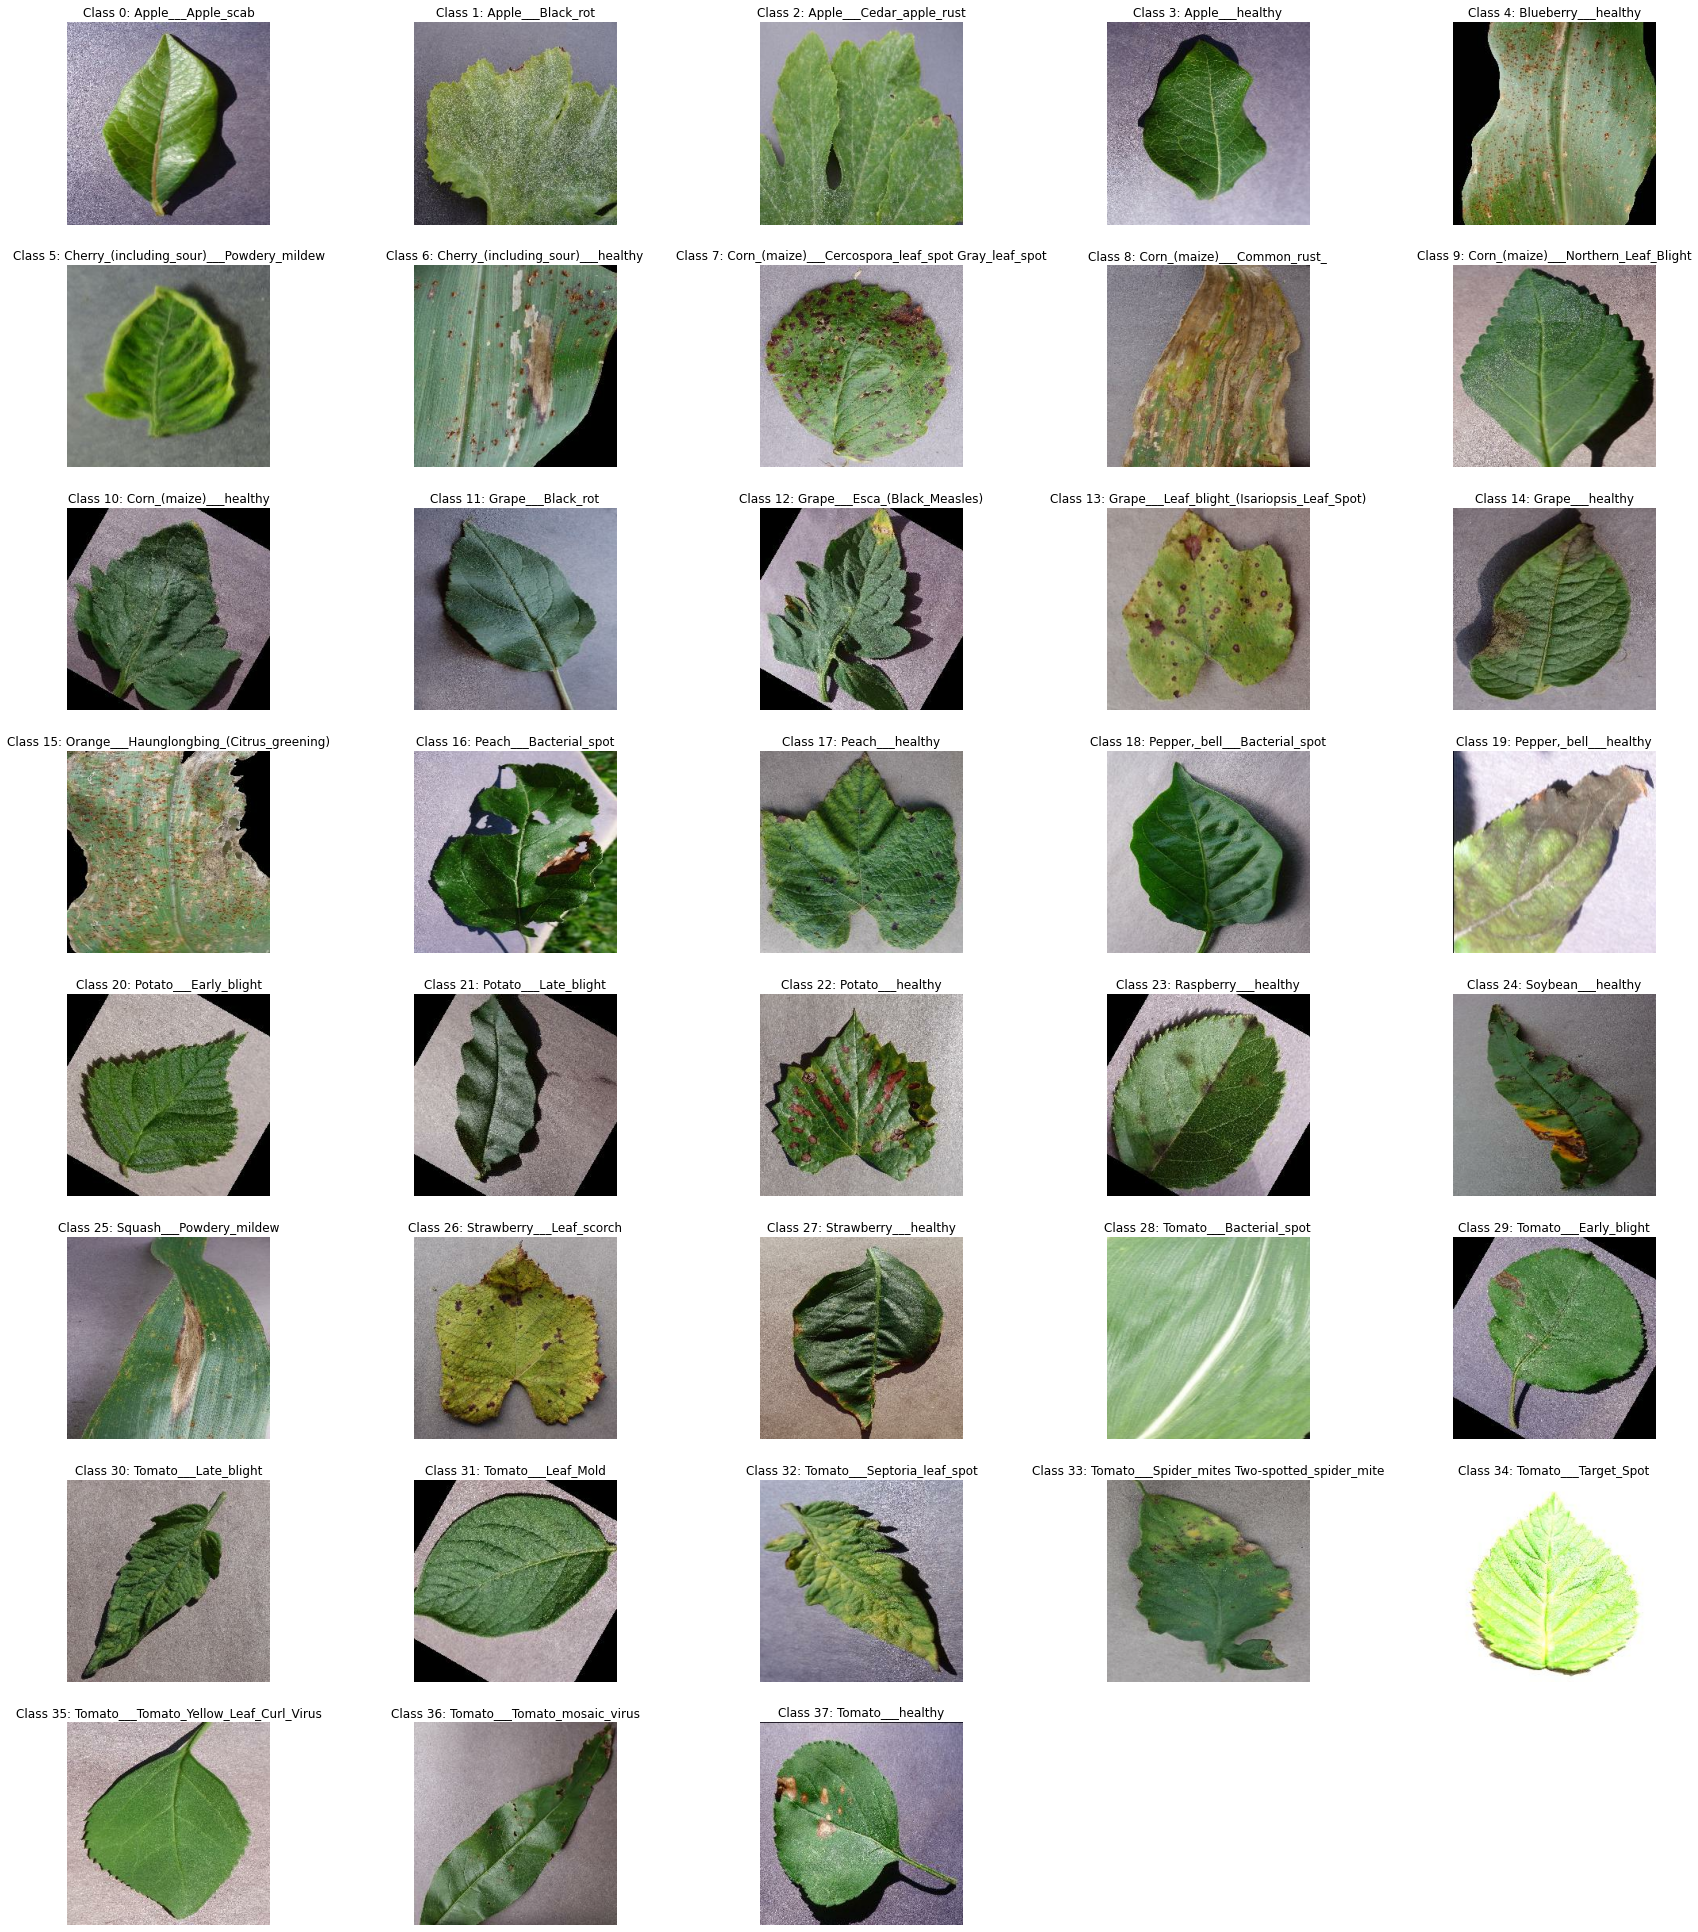

In [ ]:
plt.figure(figsize=(30, 35))

for i in range(len(class_names)): # For each of our 38 classes
    filtered_ds = train_ds_data_analysis.filter(lambda x, label: tf.math.equal(label[0], i)) # we get only the images having the label of the class of the iteration
    for image, label in filtered_ds.take(1): #.take(n) creates a Dataset with at most 'n' elements from this dataset It's a method from tf.data.Dataset
        ax = plt.subplot(8, 5, i+1) # i+1 element in table of 8 x 5 subplots (subplots indexes go from 1 to 40, and classes from 0 to 37)
        plt.imshow(image[1].numpy().astype('uint8')) # images in dataset are in tensor format with shape=(256, 256, 3) and with float32 type values between 0 and 255
# plt.imshow only accepts either a float array of values between 0 and 1, or an unsigned (positive) integer array of values between 0 and 255 (uint8, 8 bits, 256 possible values)
# => we turn it from tensor format to an array and from float32 to uint8, to display data as an image 
        plt.title(f'Class {i}: ' + class_names[label.numpy()[0]])
        plt.axis('off') # hide the axis (both x-axis and y-axis) in the matplotlib figure
        plt.subplots_adjust(hspace=0.2) # sets height of the padding between subplots to 50% of the height of the average Axes height

### Data Balancing
We can check if we have a balanced dataset for each species.

#### TRAIN SET 

Total of images of each type (.jpg / .JPG) for every class

In [ ]:
# Get all paths
train_data_path_list = list(data_dir_train.glob('*'))

# Count images with .jpg extension 
nb_img_train_jpg = [len(list(path.glob('*.jpg'))) for path in train_data_path_list]
print('Number of .jpg per folder:\n', nb_img_train_jpg)

# Count images with .JPG extension 
nb_img_train_JPG = [len(list(path.glob('*.JPG'))) for path in train_data_path_list]
print('Number of .JPG per folder:\n', nb_img_train_JPG)

Number of .jpg per folder:
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 213, 235, 0, 0, 0, 0, 0, 0, 19, 0, 0, 0, 0, 1, 0, 1, 0, 0, 146, 1, 0, 0, 0, 0, 0, 0, 1831]
Number of .JPG per folder:
 [2016, 1987, 2008, 1760, 1826, 1816, 1907, 1920, 1683, 1692, 1888, 1429, 1673, 2010, 1722, 1728, 1838, 2022, 1824, 1717, 1939, 1939, 1781, 1913, 1987, 1824, 1773, 1702, 1920, 1705, 1925, 1745, 1741, 1827, 1882, 1961, 1790, 28]


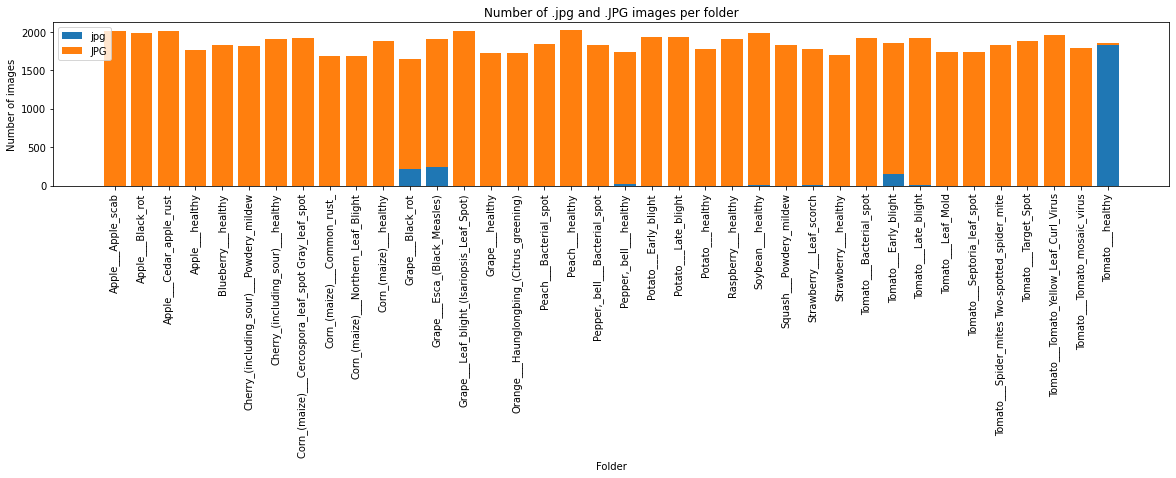

In [ ]:
# Bar plot for number of .jpg and .JPG images
plt.figure(figsize=(20,3))
plt.bar(train_ds_data_analysis.class_names, nb_img_train_jpg, label='jpg')
plt.bar(train_ds_data_analysis.class_names, nb_img_train_JPG, label='JPG', bottom=nb_img_train_jpg) #bottom parameter to avoid superposition
plt.xticks(rotation = 90)
plt.xlabel('Folder')
plt.ylabel('Number of images')
plt.title('Number of .jpg and .JPG images per folder')
plt.legend(loc='best');

Total of images of both types (.jpg + .JPG) for every class

In [ ]:
n_image = []
for class_name in train_ds_data_analysis.class_names: # for every folder name (name of each class) in the list of class names from our dataset
  # Count all images (.JPG and .jpg extensions) inside each folder
  image_count = len(list(data_dir_train.glob(class_name + '/*.JPG'))) + len(list(data_dir_train.glob(class_name + '/*.jpg')))
  # and append the values to the empty n_image list
  n_image.append(image_count)

print(n_image)
  

[2016, 1987, 1760, 2008, 1816, 1683, 1826, 1642, 1907, 1908, 1859, 1888, 1920, 1722, 1692, 2010, 1838, 1728, 1913, 1988, 1939, 1939, 1824, 1781, 2022, 1736, 1774, 1824, 1702, 1920, 1851, 1882, 1745, 1741, 1827, 1961, 1790, 1926]


Ratio of delta (vs. folder mean and vs. dataset)

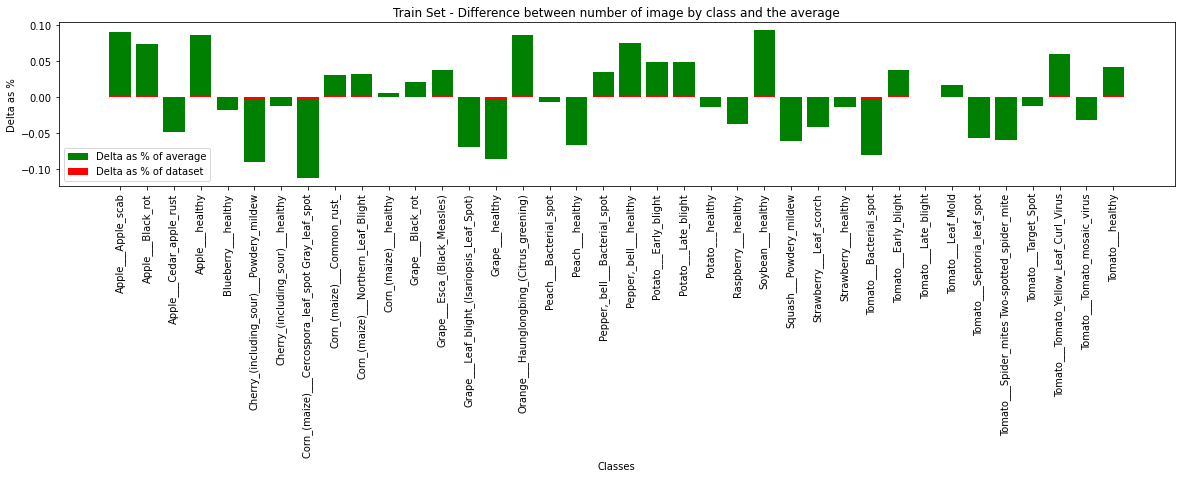

In [ ]:
# Calculation and plot of the ratio of delta (number of images in each folder - average number of images per folder in the dataset)
  # to this average (in green)
  # to the total of images in the dataset (in red) 
plt.figure(figsize=(20, 3))
tot_image_count = sum(n_image)
average_n_image  = tot_image_count/float(len(n_image))
delta_img_perc_average = [(n_img-average_n_image)/average_n_image for n_img in n_image]
delta_img_perc_dataset = [(n_img-average_n_image)/tot_image_count for n_img in n_image]
plt.bar(train_ds_data_analysis.class_names, delta_img_perc_average, color = 'g', label='Delta as % of average')
plt.bar(train_ds_data_analysis.class_names, delta_img_perc_dataset, color = 'r', label='Delta as % of dataset')
plt.xticks(rotation=90)
plt.title('Train Set - Difference between number of image by class and the average')
plt.xlabel('Classes')
plt.ylabel('Delta as %')
plt.legend()
plt.show()

#### TEST SET

Total of images of each type (.jpg / .JPG) for every class

In [ ]:
# Get all paths
test_data_path_list = list(data_dir_test.glob('*'))

# Count images with .jpg extension 
nb_img_test_jpg = [len(list(path.glob('*.jpg'))) for path in test_data_path_list]
print('Number of .jpg per folder:\n', nb_img_test_jpg)

# Count images with .JPG extension 
nb_img_test_JPG = [len(list(path.glob('*.JPG'))) for path in test_data_path_list]
print('Number of .JPG per folder:\n', nb_img_test_JPG)

Number of .jpg per folder:
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 451, 0, 0, 54, 55, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 1, 0, 0, 0, 30, 0, 0, 0, 0, 0, 0, 0]
Number of .JPG per folder:
 [496, 504, 440, 502, 423, 480, 456, 421, 454, 14, 472, 477, 423, 355, 430, 503, 432, 459, 445, 478, 505, 456, 497, 485, 426, 485, 443, 456, 425, 480, 433, 481, 435, 457, 448, 470, 436, 490]


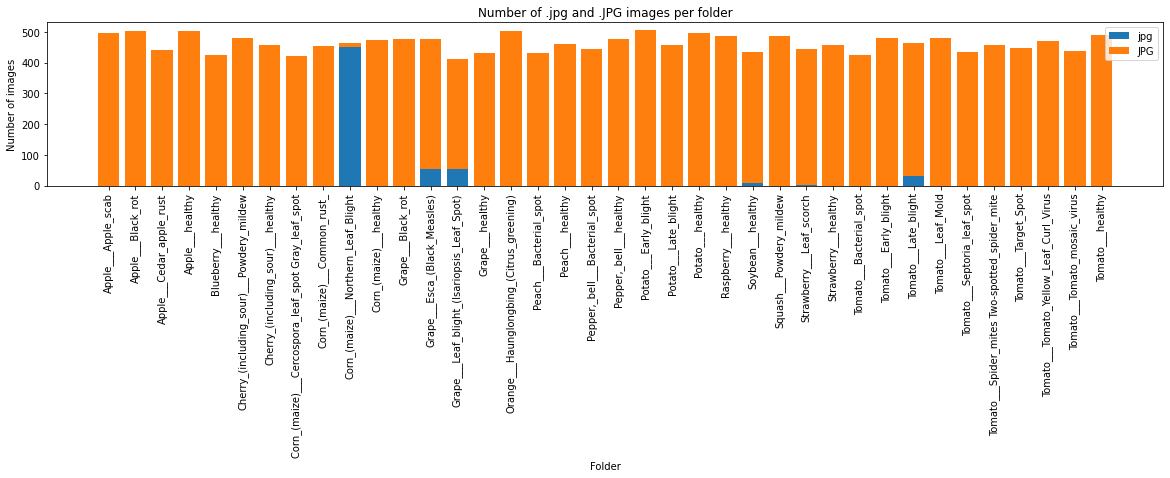

In [ ]:
# Bar plot for number of .jpg and .JPG images
plt.figure(figsize=(20,3))
plt.bar(test_ds_data_analysis.class_names, nb_img_test_jpg, label='jpg')
plt.bar(test_ds_data_analysis.class_names, nb_img_test_JPG, label='JPG', bottom=nb_img_test_jpg) #bottom parameter to avoid superposition
plt.xticks(rotation = 90)
plt.xlabel('Folder')
plt.ylabel('Number of images')
plt.title('Number of .jpg and .JPG images per folder')
plt.legend(loc='best');

Total of images of both types (.jpg + .JPG) for every class

In [ ]:
# Images by class for Test Set
n_image = []
for class_name in test_ds_data_analysis.class_names: # for every folder name (name of each class) in the list of class names from our dataset  
  # Count all images (.JPG and .jpg extensions) inside each folder
  image_count = len(list(data_dir_test.glob(class_name + '/*.JPG'))) + len(list(data_dir_test.glob(class_name + '/*.jpg')))
  # and append the values to the empty n_image list
  n_image.append(image_count)

print(n_image)

[504, 496, 440, 502, 454, 421, 456, 410, 477, 477, 465, 472, 480, 430, 423, 503, 459, 432, 478, 497, 485, 485, 456, 445, 505, 434, 444, 456, 425, 480, 463, 470, 436, 435, 457, 490, 448, 481]


Ratio of delta (vs. folder mean and vs. dataset)

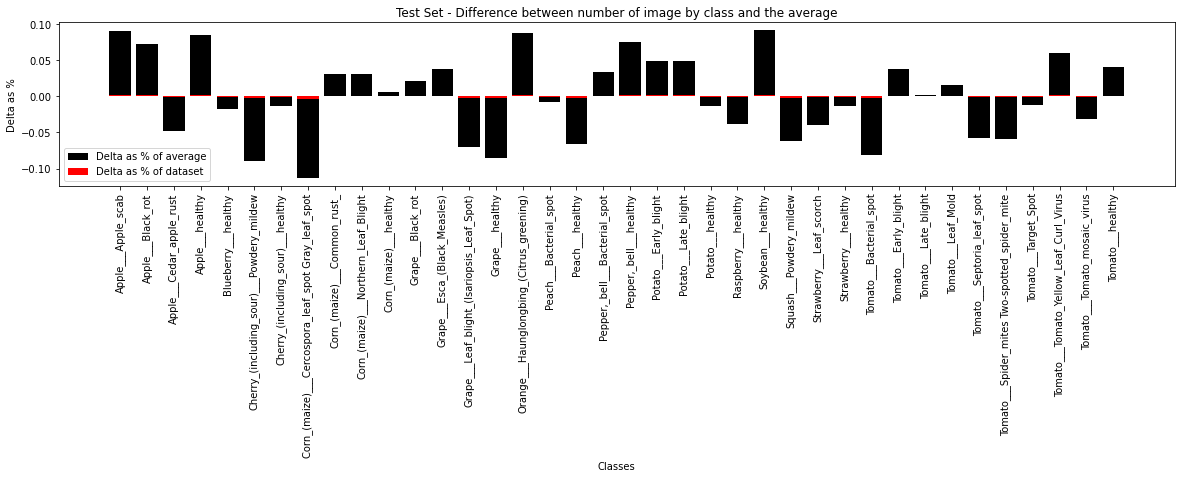

In [ ]:
plt.figure(figsize=(20, 3))
tot_image_count = sum(n_image)
average_n_image  = tot_image_count/float(len(n_image))
delta_img_perc_average = [(n_img-average_n_image)/average_n_image for n_img in n_image]
delta_img_perc_dataset = [(n_img-average_n_image)/tot_image_count for n_img in n_image]
plt.bar(test_ds_data_analysis.class_names, delta_img_perc_average, color = 'k', label='Delta as % of average')
plt.bar(test_ds_data_analysis.class_names, delta_img_perc_dataset, color = 'r', label='Delta as % of dataset')
plt.xticks(rotation=90)
plt.title('Test Set - Difference between number of image by class and the average')
plt.xlabel('Classes')
plt.ylabel('Delta as %')
plt.legend()
plt.show()

We can say that our dataset is quite balanced. The differences in the number of images by species are negligeables at the scale of the dataset. For some classes the difference vs. the average is more than 10% of the average, but this is because there are many species so the average number of images per folder is low.

##The Models

### A first CNN model



#### Presentation
We are going to train a deep convolutional network on the dataset. We implement this model with the famous libraries tensorflow and keras. Convolutional networks are widely used in image regcognizion.
Let's start with the model below. In order to speed up the first trainings, we first keep 200 images in each initial directory in one folder named train_min.

#### Choice of the Dataset: we choose the reduced dataset for initial model tests

In [ ]:
### Choice of dataset for running the models ###

# Variable 'dataset' = "reduced" (no case sensitive) --> Reduced Dataset
# Otherwise --> Reduced Dataset

# We choose the full dataset to explore data:
dataset = "reduced"

if dataset.lower() == "reduced":
  # Reduced Dataset
  data_dir_train = data_dir_train_min
  data_dir_test = data_dir_test_min
else:
  # Full Dataset
  data_dir_train = data_dir_train_full
  data_dir_test = data_dir_test_full

#### Definition of Train and Test sets for reduced dataset model

#### Definition and preprocessing of Train, Validation and Test sets
 Train and Validation are obtained splitting the Train Dataset

In [ ]:
# Define Batch Size and image size
batch_size =  32 # reference batch size from training notebooks

img_height = 256 # original image height
img_width = 256 # original image width

# Create datasets

# image_dataset_from_directory produces a A tf.data.Dataset object => batches of images form the subdirectories, together with their labels
# and splits at the same time the contents of the folder "train" in Training and Validation Set
# the tf.data.Dataset format is a tuple (images, labels), where images has shape (batch_size, image_size[0], image_size[1], num_channels),
# and labels format depends on label_mode choice
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,  
  subset="training", 
  label_mode = 'categorical', # labels are encoded as a categorical vector (e.g. for categorical_crossentropy loss)
  # labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
  # this parameter choice is linked with the CNN model's output layer activation funcion choice (softmax)
  seed=123, # we set a seed for reproducibility
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train, 
  validation_split=0.2, 
  subset="validation", 
  label_mode = 'categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=512) # we use a bigger batch size for validation dataset to speed up testing, 
  # better using the hardware. It shouldn't make any difference on validation results

# Test Set : we take the whole existing test set
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size= 512) # we use a bigger batch size for test dataset to speed up testing, 
  # better using the hardware. It shouldn't make any difference on test results

# from the total of 87866 images on both the original training and test set, we have the final distribution:
  # 56236 images for training set: 64 %
  # 14059 images for validation set: 16 %
  # 17571 images for test set: 20 %  

# Preprocessing and generation of train_gen, valid_gen, test_gen
# We define the rescaling => we turn array values in the images from a 0-255 range to a 0-1 range for the model
rescale = Rescaling(scale=1.0/255)

# We apply the rescaling to the 3 datasets
train_gen = train_ds.map(lambda image,label:(rescale(image),label))
valid_gen  = val_ds.map(lambda image,label:(rescale(image),label))
test_gen  = test_ds.map(lambda image,label:(rescale(image),label))

Found 70295 files belonging to 38 classes.
Using 56236 files for training.
Found 70295 files belonging to 38 classes.
Using 14059 files for validation.
Found 17571 files belonging to 38 classes.


#### Instance
The Convolutional Neural Network (CNN) is defined below. It contains 10 convolutional layers and 2 dense layers.

In [ ]:
# Definition of a function to build a sequential CNN model. 

# This model is built as a stack of multiple layers of different types with different functionalities

# We have 3 types of layers: input layers (raw input), hidden layers (input from another layer), and output layers (make a prediction).
# Hidden layers typically use the same activation function. The output layer will use a different activation function 
# depending on the type of prediction required by the model.
# The layers used in the model are:

  # Convolutional layer: it applies a filter (a set of weights) to the input to extract features (create a feature map).
  # the filter is applied by convolution (an element-wise multiplication of two matrices followed by a sum).
    # It's main parameters are: 
    #   Number of filters: we can stack multiple convolutional layers, with an increasing number of filters 
    #     (usually 32, 64, 128, 256 and 512), to learn multiple features in parallel (we'll have 32 to 512 different 
    #     ways of extracting features from an input)
    #   Kernel size: it's the filter size, a 2-tuple specifying the width and height of the 2D convolution window 
    #     (usually 1x1, 3x3, 5x5 or 7x7). We can start with bigger filter sizes to learn larger features and quickly
    #     reduce dimensions, and then reduce the filter size. We'll start with 7x7, then 5x5 and finish with 3x3
    #   Activation: function to be applied after filtering. Typically Rectified Linear Activation (ReLU) for hidden 
    #     layers, as it's less susceptible to vanishing gradients problem than Logistic (Sigmoid) and 
    #     Hyperbolic Tangent (Tanh). For output layers, the typical choice is Softmax (outputs a vector of values 
    #     that sum to 1.0, that can be interpreted as probabilities of class membership). Target labels used to train
    #     a model with softmax output layer will be vectors with 1 for the target class and 0 for all other classes.
    #   Padding: addition of pixels to the edge to avoid border effect due to filtering. If set to "same", 
    #   it adds the padding required to the input image to ensure that the output has the same shape as the input.

  # Max pooling layer: used to reduce the spatial dimensions of the output by taking the maximum value over an input window.
  # We get a summarized version of the features detected in the input. 
  # Main parameter is pool_size (window size), typically 2x2 or 3x3

  # Flatten layer: used to turn the 2d filter maps (the output of the convolutional layers) to create a single long feature 1-dimensional array
  # We need to pass a feature vector into a dense layer for classification.

  # Dense layer: used to classify image based on output from convolutional layers. Each neuron receives input from all the neurons 
  # of previous layer. Its main hyperparameters are:
  #   Units: dimensionality of the output vector => it has to be 38 (the number of plant classes) for the last layer
  #   Activation: typically Softmax for the last layer (gives probabilities of class membership)
  
  # Dropout: randomly sets input units to 0 (with a frequency of its rate parameter) at each step during training, which helps prevent overfitting
  # Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged. Its main parameter is:
  #   Rate: Float between 0 and 1. Fraction of the input units to drop. 



def build_model():

  model = Sequential()
  
  model.add(Conv2D(32,(7,7),activation="relu",padding="same",input_shape=(img_height,img_width,3)))
  model.add(Conv2D(32,(7,7),activation="relu",padding="same"))
  
  model.add(MaxPooling2D(3,3))

  model.add(Conv2D(64,(5,5),activation="relu",padding="same"))
  model.add(Conv2D(64,(5,5),activation="relu",padding="same"))

  model.add(MaxPooling2D(3,3))

  model.add(Conv2D(128,(3,3),activation="relu",padding="same"))
  model.add(Conv2D(128,(3,3),activation="relu",padding="same"))

  model.add(MaxPooling2D(3,3))

  model.add(Conv2D(256,(3,3),activation="relu",padding="same"))
  model.add(Conv2D(256,(3,3),activation="relu",padding="same"))

  model.add(Conv2D(512,(3,3),activation="relu",padding="same"))
  model.add(Conv2D(512,(3,3),activation="relu",padding="same"))

  model.add(Flatten())

  model.add(Dense(512,activation="relu"))
  
  model.add(Dropout(0.5))

  model.add(Dense(38,activation="softmax"))

  # Define model optimizer (optimizes the input weights by comparing the prediction and the loss function)
  # We choose Adam optimizer, with an initial learning_rate = 0.0001.
  # Adam optimizer modifies the learning_rate as needed during training
  opt = keras.optimizers.Adam(learning_rate=0.0001) 

  model.compile(
      optimizer=opt,
      loss="categorical_crossentropy", # Computes the crossentropy loss between the labels and predictions.
      # our labels are provided in a one_hot representation (dataset label_mode=categorical)
      metrics=['accuracy'])

  return model

model = build_model()
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_240 (Conv2D)         (None, 256, 256, 32)      4736      
                                                                 
 conv2d_241 (Conv2D)         (None, 256, 256, 32)      50208     
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 85, 85, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_242 (Conv2D)         (None, 85, 85, 64)        51264     
                                                                 
 conv2d_243 (Conv2D)         (None, 85, 85, 64)        102464    
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 28, 28, 64)       0         
 g2D)                                                

####  Training and saving the trained model
The choice for loss calculation is the categorical_crossentropy function, as we have labels provided in a one_hot format
We use the Adam optimizer with a learning rate of 0.001.

In [ ]:
model = build_model()

# First model training => with learning_rate = 0.001
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', 
              optimizer=opt,                
              metrics=['accuracy'])           

model_history = model.fit(train_gen, validation_data = valid_gen, epochs = 10)

Epoch 1/10
190/190 [==============================] - 56s 290ms/step - loss: 3.6558 - accuracy: 0.0212 - val_loss: 3.6386 - val_accuracy: 0.0224
Epoch 2/10
190/190 [==============================] - 48s 253ms/step - loss: 3.6381 - accuracy: 0.0260 - val_loss: 3.6391 - val_accuracy: 0.0197
Epoch 3/10
190/190 [==============================] - 48s 254ms/step - loss: 3.6379 - accuracy: 0.0280 - val_loss: 3.6394 - val_accuracy: 0.0197
Epoch 4/10
190/190 [==============================] - 48s 253ms/step - loss: 3.6379 - accuracy: 0.0280 - val_loss: 3.6399 - val_accuracy: 0.0197
Epoch 5/10
190/190 [==============================] - 48s 254ms/step - loss: 3.6381 - accuracy: 0.0270 - val_loss: 3.6400 - val_accuracy: 0.0197
Epoch 6/10
190/190 [==============================] - 48s 254ms/step - loss: 3.6379 - accuracy: 0.0280 - val_loss: 3.6401 - val_accuracy: 0.0197
Epoch 7/10
190/190 [==============================] - 48s 253ms/step - loss: 3.6378 - accuracy: 0.0265 - val_loss: 3.6404 - val_ac

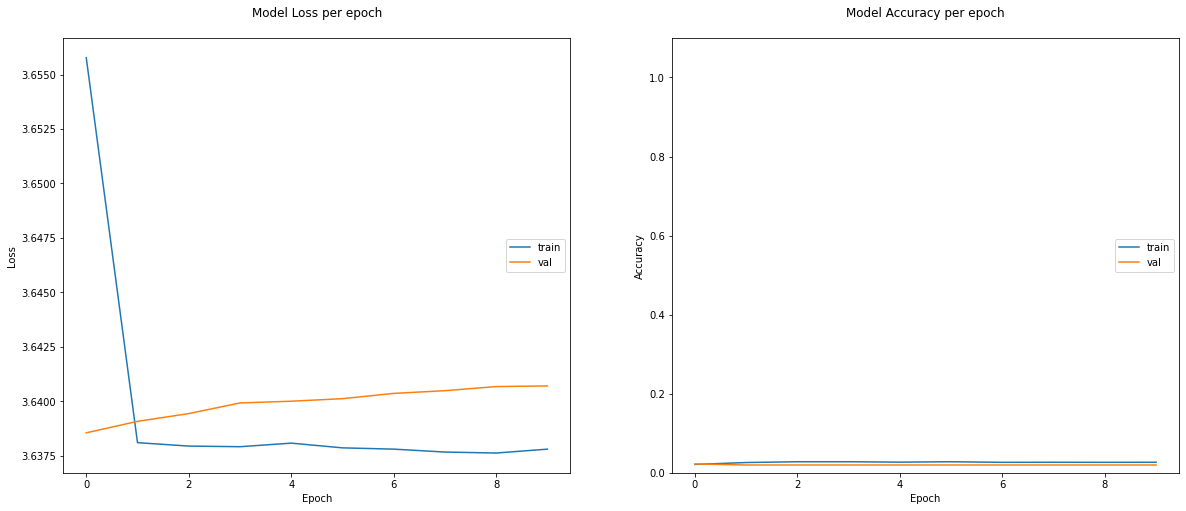

In [ ]:
graph(model_history)

We can see that the results are too bad : the model doesn't learn anything. In a second step, we gonna set the learning rate to 0.0001. But before don't forget to randomly initialize the weights of our network by calling the function build_model.

In [ ]:
model = build_model()

# 2nd model training test => with learning_rate = 0.0001 (10 times less than the 1st model test)
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', 
              optimizer=opt,                
              metrics=['accuracy'])          

model_history = model.fit(train_gen, validation_data = valid_gen, epochs = 10)

Epoch 1/10
190/190 [==============================] - 52s 266ms/step - loss: 3.5509 - accuracy: 0.0395 - val_loss: 3.4192 - val_accuracy: 0.0500
Epoch 2/10
190/190 [==============================] - 51s 265ms/step - loss: 3.2321 - accuracy: 0.1007 - val_loss: 2.8625 - val_accuracy: 0.1987
Epoch 3/10
190/190 [==============================] - 51s 266ms/step - loss: 2.7871 - accuracy: 0.2150 - val_loss: 2.4039 - val_accuracy: 0.3289
Epoch 4/10
190/190 [==============================] - 51s 266ms/step - loss: 2.3740 - accuracy: 0.3206 - val_loss: 1.9457 - val_accuracy: 0.4414
Epoch 5/10
190/190 [==============================] - 51s 266ms/step - loss: 2.0004 - accuracy: 0.4268 - val_loss: 1.5894 - val_accuracy: 0.5434
Epoch 6/10
190/190 [==============================] - 51s 266ms/step - loss: 1.6295 - accuracy: 0.5247 - val_loss: 1.4865 - val_accuracy: 0.5737
Epoch 7/10
190/190 [==============================] - 51s 266ms/step - loss: 1.3228 - accuracy: 0.6099 - val_loss: 1.2225 - val_ac

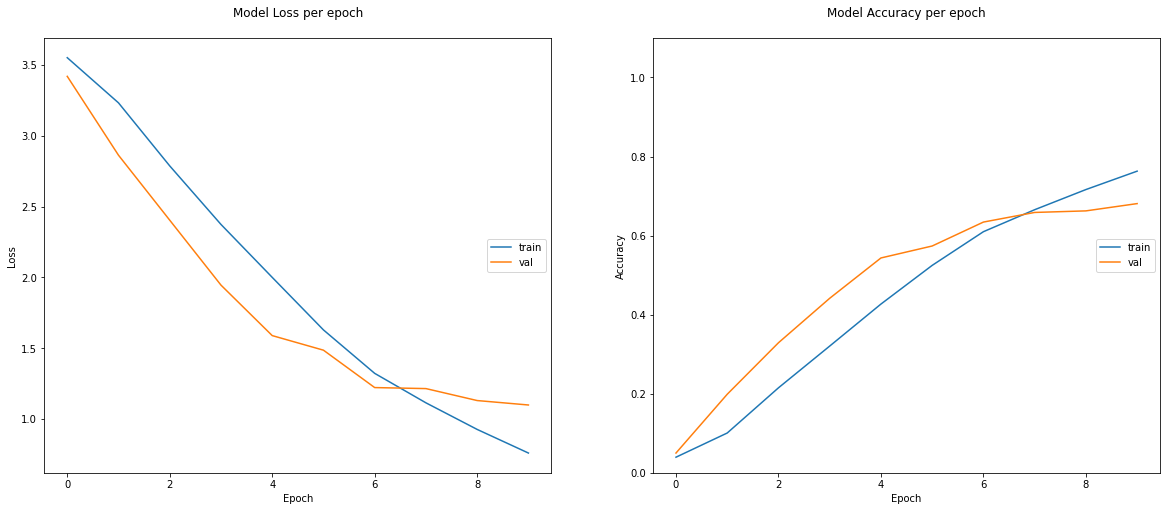

In [ ]:
graph(model_history)

It's clearly better, but still very poor performance. At least, we don't overfit (no significative difference between training accuracy and validation accuracy)

From the evolution of the curves we could say that the model just needs more "time" to get a good accuracy => Let's try increasing the number of epochs from 10 to 25.

In [ ]:
model = build_model()

# 3rd model training test with the same learning_rate but with 25 epochs instead of 10
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', 
              optimizer=opt,                
              metrics=['accuracy'])            

model_history = model.fit(train_gen, validation_data = valid_gen, epochs = 25)

Epoch 1/25
190/190 [==============================] - 52s 266ms/step - loss: 3.5886 - accuracy: 0.0383 - val_loss: 3.3737 - val_accuracy: 0.0658
Epoch 2/25
190/190 [==============================] - 51s 265ms/step - loss: 3.2032 - accuracy: 0.1077 - val_loss: 2.8203 - val_accuracy: 0.2500
Epoch 3/25
190/190 [==============================] - 51s 265ms/step - loss: 2.7727 - accuracy: 0.2127 - val_loss: 2.3990 - val_accuracy: 0.3336
Epoch 4/25
190/190 [==============================] - 51s 265ms/step - loss: 2.4155 - accuracy: 0.3145 - val_loss: 2.0455 - val_accuracy: 0.4303
Epoch 5/25
190/190 [==============================] - 51s 265ms/step - loss: 2.0397 - accuracy: 0.4095 - val_loss: 1.8242 - val_accuracy: 0.4671
Epoch 6/25
190/190 [==============================] - 51s 265ms/step - loss: 1.7263 - accuracy: 0.4893 - val_loss: 1.5196 - val_accuracy: 0.5526
Epoch 7/25
190/190 [==============================] - 51s 265ms/step - loss: 1.4361 - accuracy: 0.5719 - val_loss: 1.4226 - val_ac

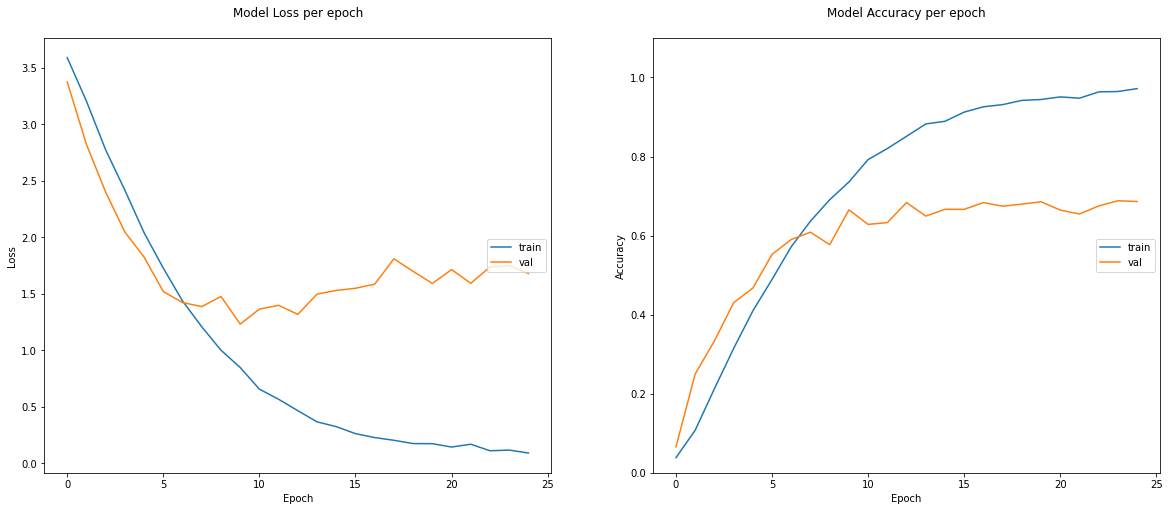

In [ ]:
graph(model_history)

WE can see that the model starts overfitting afer 7 epochs. This may mean we need a bigger dataset. Let's plot the confusion matrix on the test dataset and try with the full dataset

<Figure size 1440x360 with 0 Axes>

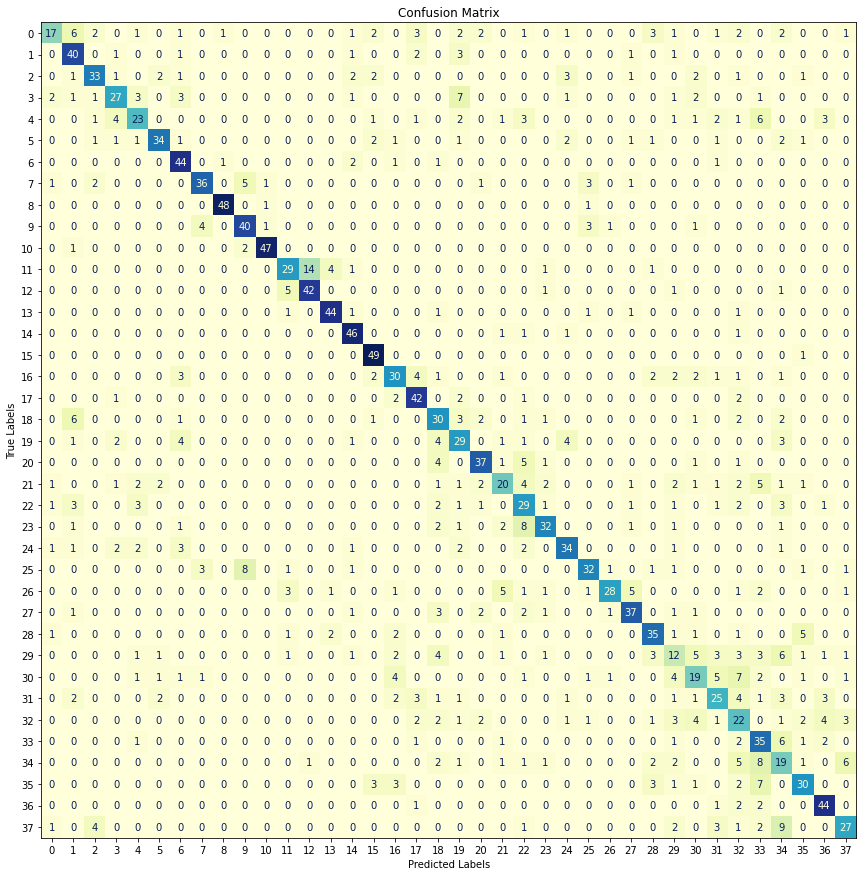

In [ ]:
num_class = 38

# We build the predictions and labels arrays, starting by initializing empty arrays
predictions = np.array([])
labels =  np.array([])

for x, y in test_gen: # for each image (x) and label (y) in our rescaled test dataset (test_gen)

  # we add the predicted label (the index of the maximum values (argmax) along the last axis (-1)
  # of the the predict(x) array) into the predictions empty array
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])

  # we add the real label (the index of the maximum values (argmax) along the last axis (-1)
  # of the the label array (y.numpy()) into the labels empty array
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

# Display the confusion matrix
conf_matrix(labels, predictions, num_class)

We can see that classes that get wrongly classified more often are: 

*   class 11 (Grape___Black_rot), predicted 14 times as class 12 (Grape___Esca_Black_Measles). We are confusing diseases of the same species
*   class 34 (Tomato___Target_Spot) predicted 8 times as class 33 (Tomato___Spider_mites Two-spotted_spider_mite) and 6 times as 37(Tomato___healthy). Again, we are confusing diseases of the same species

Now let's see the classification report on the test set.

In [ ]:
classif_report(labels, predictions, model_history=model_history)

              precision    recall  f1-score   support

         0.0      0.680     0.340     0.453        50
         1.0      0.625     0.800     0.702        50
         2.0      0.750     0.660     0.702        50
         3.0      0.675     0.540     0.600        50
         4.0      0.605     0.460     0.523        50
         5.0      0.810     0.680     0.739        50
         6.0      0.688     0.880     0.772        50
         7.0      0.818     0.720     0.766        50
         8.0      0.960     0.960     0.960        50
         9.0      0.727     0.800     0.762        50
        10.0      0.940     0.940     0.940        50
        11.0      0.707     0.580     0.637        50
        12.0      0.737     0.840     0.785        50
        13.0      0.863     0.880     0.871        50
        14.0      0.767     0.920     0.836        50
        15.0      0.790     0.980     0.875        50
        16.0      0.625     0.600     0.612        50
        17.0      0.712    

The results are not very good, specially on the tomato classes, but the model has been trained on a reduced dataset. We can save the model.

In [ ]:
model.save('gdrive/My Drive/New Plant Diseases/Modèles/CNN_RDS_bs32_25e.h5')

#### Model training on the global dataset

#### Choice of the Dataset: we choose the full dataset for final model

In [ ]:
### Choice of dataset for running the models ###

# Variable 'dataset' = "reduced" (no case sensitive) --> Reduced Dataset
# Otherwise --> Reduced Dataset

# We choose the full dataset to explore data:
dataset = "NReduced"

if dataset.lower() == "reduced":
  # Reduced Dataset
  data_dir_train = data_dir_train_min
  data_dir_test = data_dir_test_min
else:
  # Full Dataset
  data_dir_train = data_dir_train_full
  data_dir_test = data_dir_test_full

#### Definition of Train and Test sets for full dataset model

In [ ]:
# Define Batch Size and image size
batch_size =  32 # reference batch size from training notebooks

img_height = 256 # original image height
img_width = 256 # original image width

# Create datasets

# image_dataset_from_directory produces a A tf.data.Dataset object => batches of images form the subdirectories, together with their labels
# and splits at the same time the contents of the folder "train" in Training and Validation Set
# the tf.data.Dataset format is a tuple (images, labels), where images has shape (batch_size, image_size[0], image_size[1], num_channels),
# and labels format depends on label_mode choice
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,  
  subset="training", 
  label_mode = 'categorical', # labels are encoded as a categorical vector (e.g. for categorical_crossentropy loss)
  # labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
  # this parameter choice is linked with the CNN model's output layer activation funcion choice (softmax)
  seed=123, # we set a seed for reproducibility
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train, 
  validation_split=0.2, 
  subset="validation", 
  label_mode = 'categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=512) # we use a bigger batch size for validation dataset to speed up validation, 
  # better using the hardware. It shouldn't make any difference on validation results


# Test Set : we take the whole existing test set

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size= 512) # we use a bigger batch size for test dataset to speed up testing, 
  # better using the hardware. It shouldn't make any difference on test results

# from the total of 87866 images on both the original training and test set, we have the final distribution:
  # 56236 images for training set: 64 %
  # 14059 images for validation set: 16 %
  # 17571 images for test set: 20 %  

# Preprocessing and generation of train_gen, valid_gen, test_gen
# We define the rescaling => we turn array values in the images from a 0-255 range to a 0-1 range for the model
rescale = Rescaling(scale=1.0/255)

# We apply the rescaling to the 3 datasets
train_gen = train_ds.map(lambda image,label:(rescale(image),label))
valid_gen  = val_ds.map(lambda image,label:(rescale(image),label))
test_gen  = test_ds.map(lambda image,label:(rescale(image),label))

Found 70295 files belonging to 38 classes.
Using 56236 files for training.
Found 70295 files belonging to 38 classes.
Using 14059 files for validation.
Found 17571 files belonging to 38 classes.


####  Training and saving the trained model

In [ ]:
model = build_model()

# We'll try directly with the 0.0001 learning rate that worked better on reduced dataset
opt = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,                   
              metrics=['accuracy'])            

# We'll start with 10 epochs
model_history = model.fit(train_gen, validation_data = valid_gen, epochs = 10)

Epoch 1/10
1758/1758 [==============================] - 474s 269ms/step - loss: 2.1786 - accuracy: 0.3858 - val_loss: 0.9876 - val_accuracy: 0.6880
Epoch 2/10
1758/1758 [==============================] - 459s 261ms/step - loss: 0.8214 - accuracy: 0.7516 - val_loss: 0.5133 - val_accuracy: 0.8357
Epoch 3/10
1758/1758 [==============================] - 458s 260ms/step - loss: 0.4574 - accuracy: 0.8566 - val_loss: 0.3585 - val_accuracy: 0.8846
Epoch 4/10
1758/1758 [==============================] - 458s 260ms/step - loss: 0.3000 - accuracy: 0.9039 - val_loss: 0.2128 - val_accuracy: 0.9291
Epoch 5/10
1758/1758 [==============================] - 458s 260ms/step - loss: 0.2218 - accuracy: 0.9288 - val_loss: 0.2056 - val_accuracy: 0.9356
Epoch 6/10
1758/1758 [==============================] - 457s 260ms/step - loss: 0.1723 - accuracy: 0.9437 - val_loss: 0.2120 - val_accuracy: 0.9335
Epoch 7/10
1758/1758 [==============================] - 458s 260ms/step - loss: 0.1343 - accuracy: 0.9558 - val_

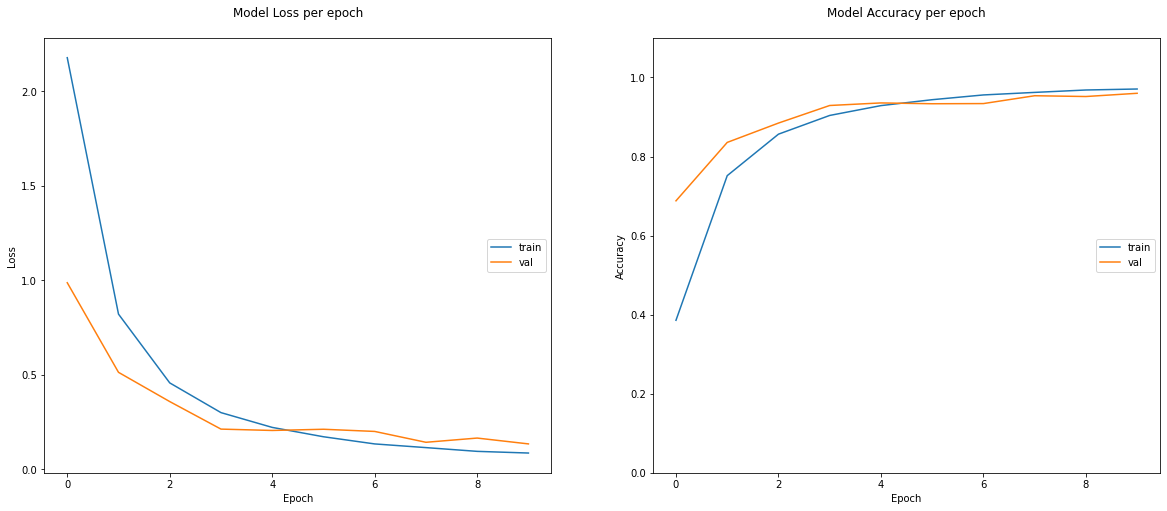

In [ ]:
graph(model_history)

These results are already pretty good, let's save the model and try increasing the number of epochs to 20 instead of 10 (from the shape of the curves, we can imagine we won't need to go up to 25 epochs to obtain good accuracy)

In [ ]:
model.save('gdrive/My Drive/New Plant Diseases/Modèles/CNN_FDS_bs32_10e.h5')

In [ ]:
model = build_model()

# We'll try directly with the 0.0001 learning rate that worked better on reduced dataset
opt = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,                   
              metrics=['accuracy'])            

# Let's try with 20 epochs
model_history = model.fit(train_gen, validation_data = valid_gen, epochs = 20)

Epoch 1/20
1758/1758 [==============================] - 459s 260ms/step - loss: 2.3043 - accuracy: 0.3504 - val_loss: 0.8842 - val_accuracy: 0.7335
Epoch 2/20
1758/1758 [==============================] - 458s 261ms/step - loss: 0.8073 - accuracy: 0.7546 - val_loss: 0.3980 - val_accuracy: 0.8723
Epoch 3/20
1758/1758 [==============================] - 458s 260ms/step - loss: 0.4489 - accuracy: 0.8612 - val_loss: 0.3077 - val_accuracy: 0.8986
Epoch 4/20
1758/1758 [==============================] - 458s 260ms/step - loss: 0.3066 - accuracy: 0.9010 - val_loss: 0.2154 - val_accuracy: 0.9307
Epoch 5/20
1758/1758 [==============================] - 457s 260ms/step - loss: 0.2275 - accuracy: 0.9273 - val_loss: 0.2725 - val_accuracy: 0.9108
Epoch 6/20
1758/1758 [==============================] - 457s 260ms/step - loss: 0.1766 - accuracy: 0.9418 - val_loss: 0.1657 - val_accuracy: 0.9448
Epoch 7/20
1758/1758 [==============================] - 457s 260ms/step - loss: 0.1442 - accuracy: 0.9523 - val_

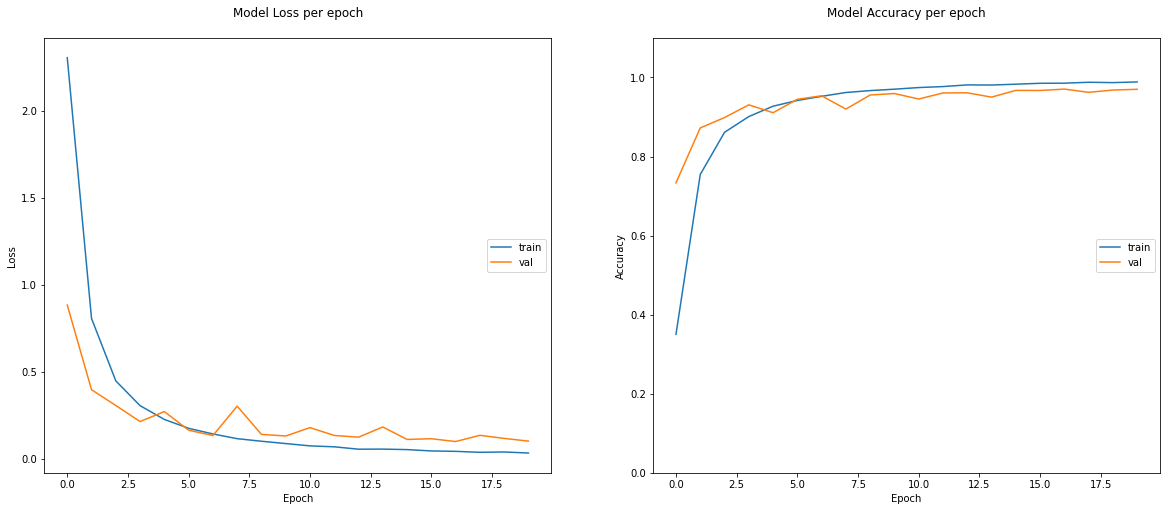

In [ ]:
graph(model_history)

#### Predictions and Analysis of Results

Let's check the confusion matrix

<Figure size 1440x360 with 0 Axes>

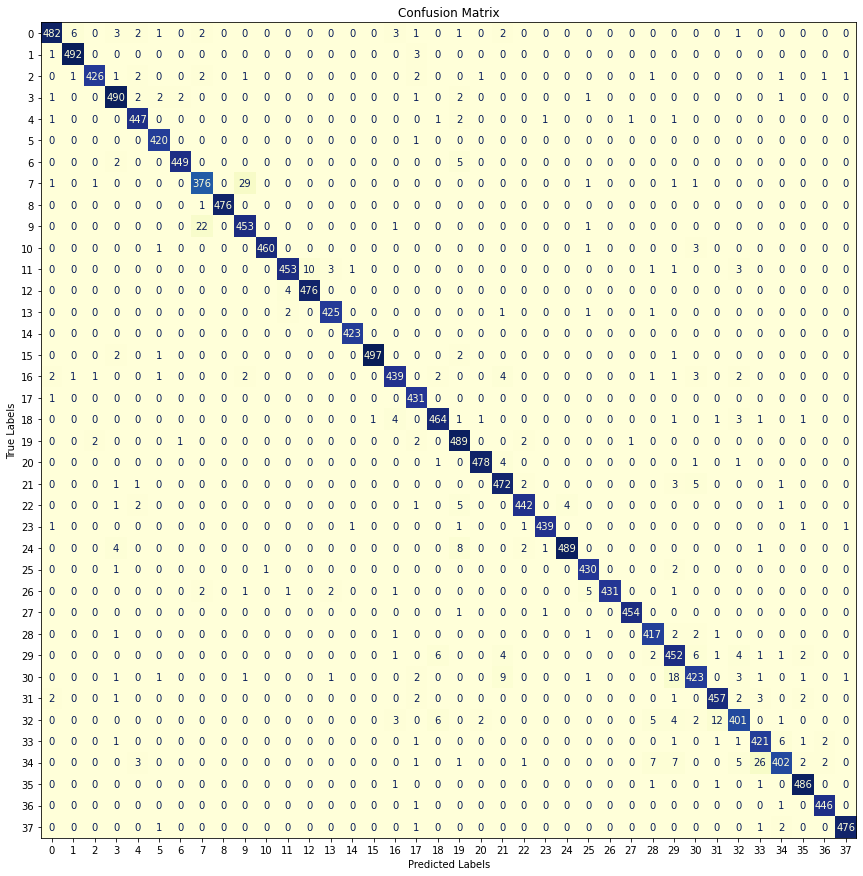

In [ ]:
num_class = 38

# We build the predictions and labels arrays, starting by initializing empty arrays
predictions = np.array([])
labels =  np.array([])

for x, y in test_gen: # for each image (x) and label (y) in our rescaled test dataset (test_gen)

  # we add the predicted label (the index of the maximum values (argmax) along the last axis (-1)
  # of the the predict(x) array) into the predictions empty array
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])

  # we add the real label (the index of the maximum values (argmax) along the last axis (-1)
  # of the the label array (y.numpy()) into the labels empty array
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

# Display the confusion matrix
conf_matrix(labels, predictions, num_class)

The most confused classes are:
- Class 7 (Corn_(maize)_______Cercospora_leaf_spot Gray_leaf_) predicted as 9 (Corn_(maize)___Northern_Leaf_Blight)
- Class 34 (Tomato___Target_Spot) predicted as 33 (Tomato___Spider_mites Two-spotted_spider_mite) 

Let's check the classification report

In [ ]:

predictions = np.array([])
labels =  np.array([])

for x, y in test_gen:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

classif_report(labels,predictions, model_history=None)

              precision    recall  f1-score   support

         0.0      0.980     0.956     0.968       504
         1.0      0.984     0.992     0.988       496
         2.0      0.991     0.968     0.979       440
         3.0      0.963     0.976     0.969       502
         4.0      0.974     0.985     0.979       454
         5.0      0.981     0.998     0.989       421
         6.0      0.993     0.985     0.989       456
         7.0      0.928     0.917     0.923       410
         8.0      1.000     0.998     0.999       477
         9.0      0.930     0.950     0.940       477
        10.0      0.998     0.989     0.994       465
        11.0      0.985     0.960     0.972       472
        12.0      0.979     0.992     0.986       480
        13.0      0.986     0.988     0.987       430
        14.0      0.995     1.000     0.998       423
        15.0      0.998     0.988     0.993       503
        16.0      0.967     0.956     0.962       459
        17.0      0.958    

We can confirm here that classes 34 and 7 are some of the worst classified (as we saw easily on the confusion matrix) => both have F1-score around 92%.

But we can also observe here that class 29 (Tomato___Early_blight) is not very well classified by the model (F1-score around 92% aswell). This is not so clear when checking the confusion matrix, as errors are spread over multiple other classes, but we can point it out easily with this classification report.

It looks like classification errors are quite concentrated on tomato leaves, which seems logical, as we have 10 classes (9 diseases).

The accuracy on both the validation and the test sets are around 97 %, which means the model has similar behavior on different "unseen" data, even if it has a small overfitting (+2% accuracy on training set).

Let's save the model

In [ ]:
model.save('gdrive/My Drive/New Plant Diseases/Modèles/CNN_FDS_bs32_20e.h5')

#### Test loading model and identifying leaf

In [ ]:
model = load_model('gdrive/My Drive/New Plant Diseases/Modèles/CNN_FDS_bs32_20e.h5')

In [ ]:
# Read image to be predicted
img = cv2.imread('gdrive/My Drive/New Plant Diseases/temp/cherry_powdery_mildew.JPG')

# Resize the image to the image size used in out model (just in case the image is not in that size)
img = resize(img, (256, 256))

# Reshape image to inject it in our model for the prediction
img = img.reshape(1,256,256,3)

# Prediction: (1, 38) array (vector) with probabilities for each class
print(model.predict(img))

# We get the class predicted with 
#   np.argmax, which outputs the index of the highest value
#   class_names (the list of our 38 classes)
print('The leaf class is: ', class_names[np.argmax(model.predict(img))])

# Alternative code if we want to use only PIL (cv2.show() makes Jupyter Notebooks crash in Collab)
# from PIL import Image
# img = Image.open('gdrive/My Drive/New Plant Diseases/temp/myrtille.JPG')
# img = img.resize(256, 256)

[[1.25874440e-05 3.11852695e-08 3.76673823e-04 6.13090873e-04
  7.60633068e-09 3.00707370e-01 7.51480798e-08 1.38322250e-07
  3.85729004e-09 1.49193482e-07 7.37029097e-07 9.43486178e-10
  1.23085195e-10 1.67667565e-07 1.76130683e-07 1.16875650e-04
  1.56523753e-02 1.53486631e-04 7.99789268e-06 6.78998113e-01
  2.97805869e-08 2.93581525e-05 1.15445619e-06 1.49896717e-09
  8.69956551e-08 3.07483811e-06 1.46072622e-07 1.39334615e-08
  3.94987751e-07 2.31551030e-03 1.00746099e-03 9.50823278e-07
  3.14544479e-08 1.15006327e-09 2.34559892e-07 1.91913998e-07
  4.97178521e-10 1.32852119e-06]]
The leaf class is:  Pepper,_bell___healthy


Just to compare with the following transfer learning models, we will try the same model, but taking a batch_size of 128 instead of 32.

We define again the datasets, but this time with a training batch size of 128

In [ ]:
# Define Batch Size and image size
batch_size =  128 # reference batch size from training notebooks

img_height = 256 # original image height
img_width = 256 # original image width

# Create datasets

# image_dataset_from_directory produces a A tf.data.Dataset object => batches of images form the subdirectories, together with their labels
# and splits at the same time the contents of the folder "train" in Training and Validation Set
# the tf.data.Dataset format is a tuple (images, labels), where images has shape (batch_size, image_size[0], image_size[1], num_channels),
# and labels format depends on label_mode choice
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,  
  subset="training", 
  label_mode = 'categorical', # labels are encoded as a categorical vector (e.g. for categorical_crossentropy loss)
  # labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
  # this parameter choice is linked with the CNN model's output layer activation funcion choice (softmax)
  seed=123, # we set a seed for reproducibility
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train, 
  validation_split=0.2, 
  subset="validation", 
  label_mode = 'categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=512) # we use a bigger batch size for validation dataset to speed up validation, 
  # better using the hardware. It shouldn't make any difference on validation results


# Test Set : we take the whole existing test set

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size= 512) # we use a bigger batch size for test dataset to speed up testing, 
  # better using the hardware. It shouldn't make any difference on test results

# from the total of 87866 images on both the original training and test set, we have the final distribution:
  # 56236 images for training set: 64 %
  # 14059 images for validation set: 16 %
  # 17571 images for test set: 20 %  

# Preprocessing and generation of train_gen, valid_gen, test_gen
# We define the rescaling => we turn array values in the images from a 0-255 range to a 0-1 range for the model
rescale = Rescaling(scale=1.0/255)

# We apply the rescaling to the 3 datasets
train_gen = train_ds.map(lambda image,label:(rescale(image),label))
valid_gen  = val_ds.map(lambda image,label:(rescale(image),label))
test_gen  = test_ds.map(lambda image,label:(rescale(image),label))

Found 70295 files belonging to 38 classes.
Using 56236 files for training.
Found 70295 files belonging to 38 classes.
Using 14059 files for validation.
Found 17571 files belonging to 38 classes.


In [ ]:
model = build_model()

# We'll try directly with the 0.0001 learning rate that worked better on reduced dataset
opt = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,                   
              metrics=['accuracy'])            

# Let's try with 20 epochs
model_history = model.fit(train_gen, validation_data = valid_gen, epochs = 20)

Epoch 1/20
440/440 [==============================] - 431s 974ms/step - loss: 2.6466 - accuracy: 0.2625 - val_loss: 1.5007 - val_accuracy: 0.5527
Epoch 2/20
440/440 [==============================] - 423s 960ms/step - loss: 1.2803 - accuracy: 0.6192 - val_loss: 0.7534 - val_accuracy: 0.7681
Epoch 3/20
440/440 [==============================] - 423s 960ms/step - loss: 0.7865 - accuracy: 0.7611 - val_loss: 0.5574 - val_accuracy: 0.8235
Epoch 4/20
440/440 [==============================] - 423s 960ms/step - loss: 0.5811 - accuracy: 0.8195 - val_loss: 0.4185 - val_accuracy: 0.8662
Epoch 5/20
440/440 [==============================] - 423s 960ms/step - loss: 0.4399 - accuracy: 0.8613 - val_loss: 0.3199 - val_accuracy: 0.8944
Epoch 6/20
440/440 [==============================] - 423s 959ms/step - loss: 0.3506 - accuracy: 0.8875 - val_loss: 0.2794 - val_accuracy: 0.9087
Epoch 7/20
440/440 [==============================] - 423s 959ms/step - loss: 0.2762 - accuracy: 0.9099 - val_loss: 0.3242 -

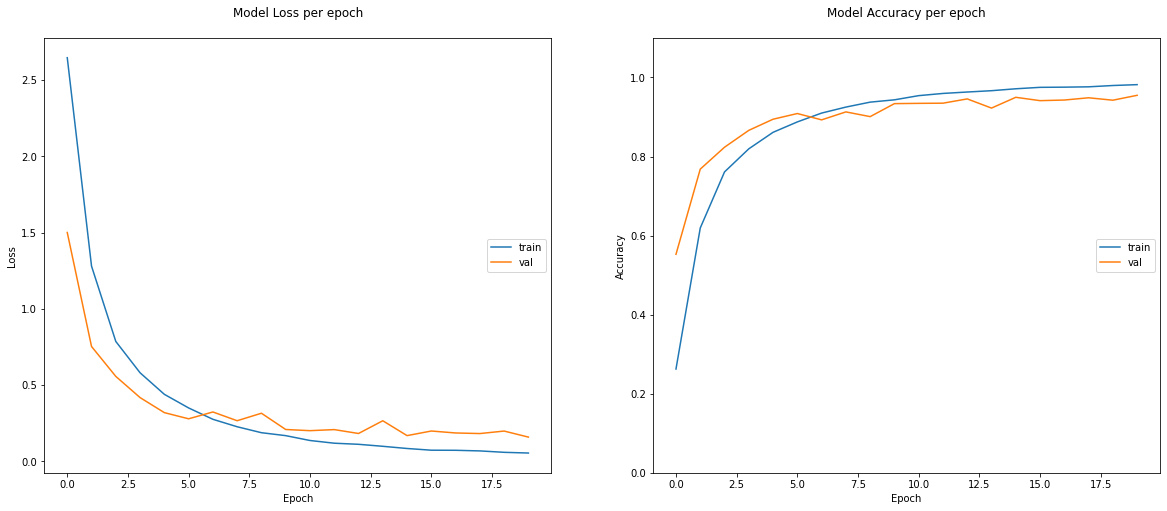

In [ ]:
graph(model_history)

Let's check the confusion matrix

<Figure size 1440x360 with 0 Axes>

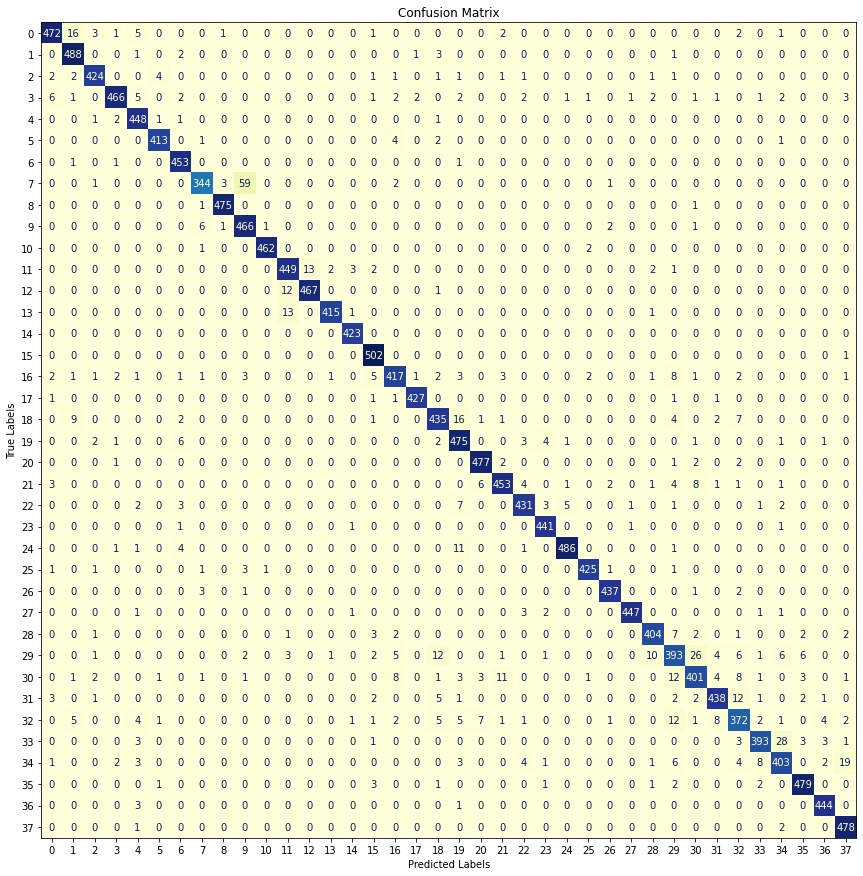

In [ ]:
num_class = 38

# We build the predictions and labels arrays, starting by initializing empty arrays
predictions = np.array([])
labels =  np.array([])

for x, y in test_gen: # for each image (x) and label (y) in our rescaled test dataset (test_gen)

  # we add the predicted label (the index of the maximum values (argmax) along the last axis (-1)
  # of the the predict(x) array) into the predictions empty array
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])

  # we add the real label (the index of the maximum values (argmax) along the last axis (-1)
  # of the the label array (y.numpy()) into the labels empty array
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

# Display the confusion matrix
conf_matrix(labels, predictions, num_class)

And let's get the classification report

In [ ]:

predictions = np.array([])
labels =  np.array([])
for x, y in test_gen:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

classif_report(labels,predictions, model_history=None)

              precision    recall  f1-score   support

         0.0      0.961     0.937     0.949       504
         1.0      0.931     0.984     0.957       496
         2.0      0.968     0.964     0.966       440
         3.0      0.977     0.928     0.952       502
         4.0      0.937     0.987     0.961       454
         5.0      0.981     0.981     0.981       421
         6.0      0.954     0.993     0.973       456
         7.0      0.958     0.839     0.895       410
         8.0      0.990     0.996     0.993       477
         9.0      0.871     0.977     0.921       477
        10.0      0.996     0.994     0.995       465
        11.0      0.939     0.951     0.945       472
        12.0      0.973     0.973     0.973       480
        13.0      0.990     0.965     0.978       430
        14.0      0.984     1.000     0.992       423
        15.0      0.954     0.998     0.976       503
        16.0      0.939     0.908     0.924       459
        17.0      0.991    

In [ ]:
model.save('gdrive/My Drive/New Plant Diseases/Modèles/CNN_FDS_bs128_20e.h5')

In [ ]:
# Typically, when using a larger batch there is a degradation in ability of the model to generalize.
# We can see here that indeed, the effect of changing batch_size from 32 to 128 is a bigger difference between 
# training and validation accuracy (from 98% to 95% => -3%), and a lower final test accuracy (from 97% to 95% => -2%)

### Transfer Learning : VGG16



#### Presentation


The VGG network was introduced in in 2013 by Karen Simonyan and Andrew Zisserman.

The network is named VGG after the department of Visual Geometry Group in the University of Oxford that the creators belonged to. 

The key idea behind VGG is investigating the possibility of creating a deep network by using a combination of several very small (3x3, the smallest size to capture the notion of left/right, up/down, center) convolution filters, rather than larger filters as the ones currently used at the time.

The consistent use of 3 x 3 convolutions across the network made the network very simple, elegant, and easy to work with. 
The VGG network secured the first and the second places at the ImageNet Challenge 2014 in the localization and classification tracks respectively.


#### Definition and preprocessing of Train, Validation and Test sets
 Train and Validation are obtained splitting the Train Dataset

In [ ]:
# Define Batch Size and image size
batch_size_train =  128 
img_height = 256
img_width = 256 


# Split the contents of the folder "train" in Training and Validation Set 

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,  
  subset="training", 
  label_mode = 'categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size_train)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train, 
  validation_split=0.2, 
  subset="validation", 
  label_mode = 'categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=128)


# Test Set 

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size= 512)


# Preprocessing and generation of train_gen, valid_gen, test_gen

from tensorflow.keras.applications.vgg16 import preprocess_input
train_gen = train_ds.map(lambda image,label:(preprocess_input(image/1.),label))
valid_gen  = val_ds.map(lambda image,label:(preprocess_input(image/1.),label))
test_gen = test_ds.map(lambda image,label:(preprocess_input(image/1.),label))







Found 70295 files belonging to 38 classes.
Using 56236 files for training.
Found 70295 files belonging to 38 classes.
Using 14059 files for validation.
Found 17571 files belonging to 38 classes.


#### Instance the Model

In [ ]:


from tensorflow.keras.layers import GlobalAveragePooling2D

n_class=38

base_model = VGG16(weights='imagenet', include_top=False,
                     classes= n_class, input_shape = (img_height,img_width,3)) 


# Freeze the layers of base_model
for layer in base_model.layers: 
    layer.trainable = False

model_VGG16 = Sequential()

model_VGG16.add(base_model)

model_VGG16.add(GlobalAveragePooling2D()) 
model_VGG16.add(Dense(1024,activation='relu'))
model_VGG16.add(Dropout(rate=0.2))
model_VGG16.add(Dense(512, activation='relu'))
model_VGG16.add(Dropout(rate=0.2))
model_VGG16.add(Dense(n_class, activation='softmax'))

print(model_VGG16.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

In [ ]:
print(base_model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

#### VGG16 Freezed

##### Definition of Names

In [ ]:
### DEFINE NAMES ###

model_name = 'VGG16_Fr_FDS'

# define the name for saving the model
model_name_to_save = model_name+'.h5'

# define the full path (including the name) for saving teh checkpoints 
checkpoint_filepath = 'gdrive/My Drive/New Plant Diseases/checkpoints/'+model_name+'.{epoch:03d}.h5'

# To be filled in the second part (WE MAY NEED TO DISCUSS A POSSIBLE STANDARD)
text_for_chart = model_name


##### Definition of the Callbacks (VGG16 Unfreeze)

In [ ]:
### DEFINE THE CALLBACKS ###
# Callbacks allow us to apply functions at given stages of the training procedure.

from tensorflow.keras import callbacks

# ModelCheckpoint => saves the model after every epoch
def check_point(checkpoint_filepath):
    return callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=False, # the whole model is saved
      monitor='val_loss', # Metric monitored : validation loss
      mode='min', # Decision to overwrite the current save file based on the minimization of val_loss
      save_best_only=True) # Only saves when model considered the "best". Latest best model according to the quantity monitored will not be overwritten (save_best_only=True)


# LearningRateScheduler => Gets updated learning rate value at the beginning of every epoch, and applies the updated learning rate on the optimizer.
def decreasinglrUpdate(epoch,learning_rate):
    if epoch % 5 == 0:
        return learning_rate * 0.2
    else: 
        return learning_rate

lrScheduler = callbacks.LearningRateScheduler(schedule=decreasinglrUpdate, verbose=1)


# EarlyStopping => stops training depending on loss to avoid overfitting. Criteria : min_delta OR patience
early_stopping = callbacks.EarlyStopping(
    monitor='loss', # quantity to be monitored
    min_delta=0.01, # if the difference in loss is less than 0.01
    restore_best_weights=True, # keeps the best weights when stopped
    patience=2, # after 2 epoch without improvement
    verbose = 1) # shows on which epoch the training has been stopped 

#ReduceLROnPlateau => reduce learning rate once learning stagnates:
  #  (factor=0.1)
reducelrplateau = callbacks.ReduceLROnPlateau(
    monitor="val_loss", #quantity to be monitored
    factor=0.1, # reduction by a factor of 10 (new_lr = lr * factor)
    patience=2, # if no improvement is seen after 2 epoch
    verbose=1, # update messages
    mode="auto", # the direction (monitored quantity stopped decreasing/increasing) is automatically inferred from the name of the monitored quantity.
    min_delta=0.01, # threshold for measuring the new optimum
    cooldown=2)  # 2 epochs wait before resuming normal operation after learning rate has been reduced.

##### Training and saving the trained model


Epoch 1: LearningRateScheduler setting learning rate to 0.00020000000949949026.
Epoch 1/20
440/440 [==============================] - 1582s 4s/step - loss: 0.7489 - accuracy: 0.7911 - val_loss: 0.1815 - val_accuracy: 0.9443 - lr: 2.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00020000000949949026.
Epoch 2/20
440/440 [==============================] - 450s 1s/step - loss: 0.2147 - accuracy: 0.9318 - val_loss: 0.1198 - val_accuracy: 0.9622 - lr: 2.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00020000000949949026.
Epoch 3/20
440/440 [==============================] - 458s 1s/step - loss: 0.1454 - accuracy: 0.9536 - val_loss: 0.0944 - val_accuracy: 0.9686 - lr: 2.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00020000000949949026.
Epoch 4/20
440/440 [==============================] - 458s 1s/step - loss: 0.1068 - accuracy: 0.9649 - val_loss: 0.0873 - val_accuracy: 0.9711 - lr: 2.0000e-04

Epoch 5: LearningRateScheduler set

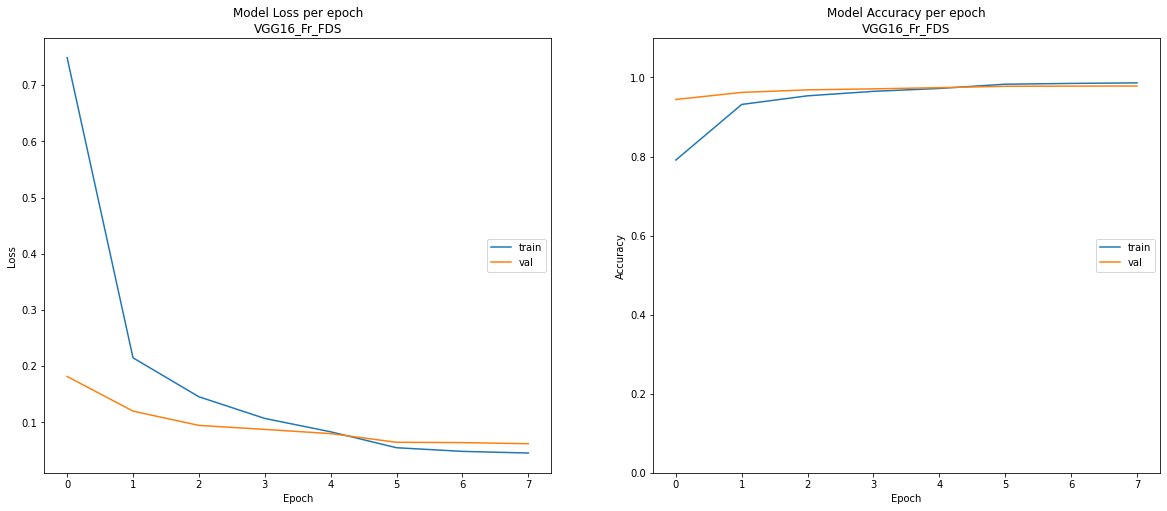

In [ ]:
# define starting learning rate
learn_rate = 0.001

# define optimizer
opt = keras.optimizers.Adam(learning_rate=learn_rate)

# define number of epochs
epochs = 20

# Finalize ModelCheckpoint
model_checkpoint_callback = check_point(checkpoint_filepath)

# compile model
model_VGG16.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
model_VGG16_history = model_VGG16.fit(train_gen, validation_data = valid_gen, epochs = epochs,
                                                callbacks=[model_checkpoint_callback, lrScheduler, early_stopping, reducelrplateau])

# save the model
model_VGG16.save(model_save_dir+model_name_to_save)


graph(model_VGG16_history,text_for_chart,)

In [ ]:
graph(model_VGG16_history,text_for_chart,1)

##### Loading of a trained model (alternative to train) 

In [ ]:
### THIS PART IS ALTERNATIVE TO TRAIN ###
# delete the variable model if it exists
if 'model_VGG16' in locals(): 
  del model_VGG16
model_name_to_load = 'VGG16_Fr_FDS.h5'
# load the model
model_VGG16= keras.models.load_model(model_save_dir+model_name_to_load)

##### Predictions and Analysis of Results

In [ ]:
### PREDICTIONS ####

#TRANSFORM TEST DATASET IN NUMPY OBJECT #
import tensorflow_datasets as tfds
ds_numpy = tfds.as_numpy(test_gen)

predictions = np.array([])
labels =  np.array([])

import progressbar
bar = progressbar.ProgressBar(maxval=17571/512, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
n=0
for x in ds_numpy:
  predictions = np.concatenate([predictions, np.argmax(model_VGG16.predict(x[-2]), axis=-1)])
  labels = np.concatenate([labels, np.argmax(x[-1], axis=-1)])
  bar.update(n)
  n+=1
bar.finish()

In [ ]:
print(classification_report(labels, predictions, digits = 3))

              precision    recall  f1-score   support

         0.0      0.982     0.980     0.981       504
         1.0      0.986     0.992     0.989       496
         2.0      0.991     0.986     0.989       440
         3.0      0.986     0.988     0.987       502
         4.0      0.996     0.993     0.994       454
         5.0      0.995     0.998     0.996       421
         6.0      0.987     0.998     0.992       456
         7.0      0.964     0.927     0.945       410
         8.0      1.000     0.996     0.998       477
         9.0      0.937     0.971     0.954       477
        10.0      1.000     1.000     1.000       465
        11.0      0.981     0.992     0.986       472
        12.0      0.992     0.988     0.990       480
        13.0      1.000     0.998     0.999       430
        14.0      1.000     1.000     1.000       423
        15.0      1.000     0.998     0.999       503
        16.0      0.981     0.996     0.988       459
        17.0      0.995    

In [ ]:
### Classification Report  ####

# If it's a loaded model leave third parameter empty (or set equal to None) 
classif_report(labels,predictions,) ## for loaded model
#classif_report(labels,predictions,model_history=model_history) ## for live trained model




              precision    recall  f1-score   support

         0.0      0.982     0.980     0.981       504
         1.0      0.986     0.992     0.989       496
         2.0      0.991     0.986     0.989       440
         3.0      0.986     0.988     0.987       502
         4.0      0.996     0.993     0.994       454
         5.0      0.995     0.998     0.996       421
         6.0      0.987     0.998     0.992       456
         7.0      0.964     0.927     0.945       410
         8.0      1.000     0.996     0.998       477
         9.0      0.937     0.971     0.954       477
        10.0      1.000     1.000     1.000       465
        11.0      0.981     0.992     0.986       472
        12.0      0.992     0.988     0.990       480
        13.0      1.000     0.998     0.999       430
        14.0      1.000     1.000     1.000       423
        15.0      1.000     0.998     0.999       503
        16.0      0.981     0.996     0.988       459
        17.0      0.995    

<Figure size 1440x360 with 0 Axes>

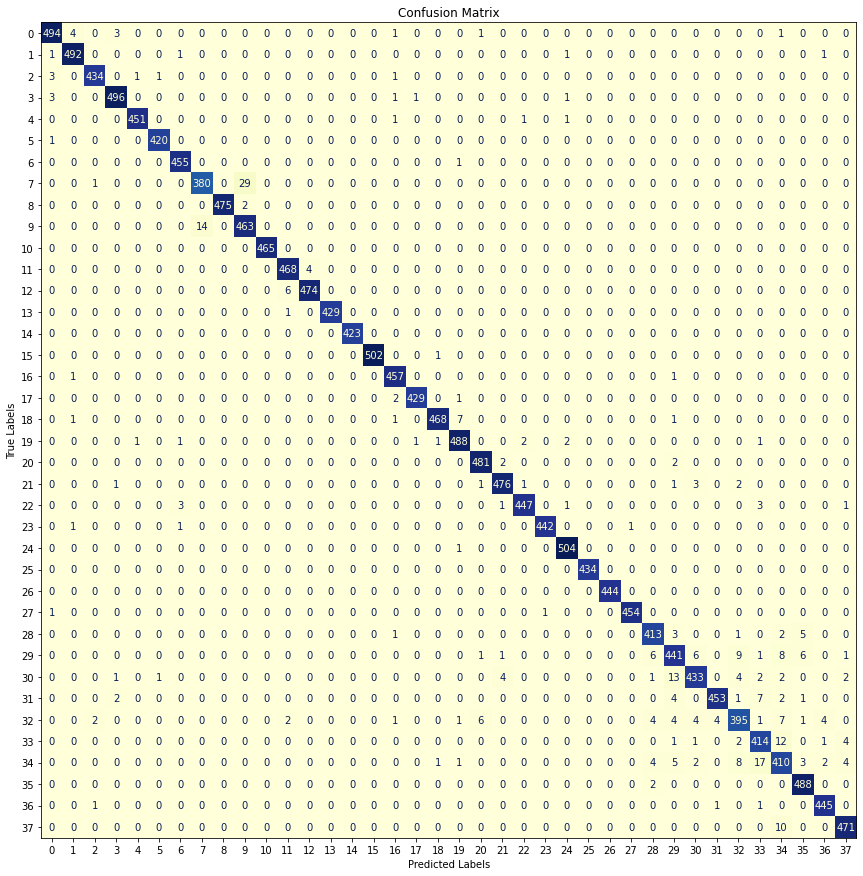

In [ ]:
  ### CONFUSION MATRIX ####
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
num_class = 38
conf_matrix(labels,predictions,num_class)

As it was already the case with our first model, looking at the F1-score by class we observe that the model struggles in classifying class 7 and 9 (both related to corn’s leaves) and the classes from 28 to 37 (the ones related to tomato’s leaves), with class 34 resulting the most difficult to classify of the whole dataset.  The Confusion Matrix shows that the model sometime inverts Class 7 and 9, while for the tomato’s leaves there is more dispersion of misclassification among the various classes 
The accuracy results are globally already quite good with an accuracy in both training and test close to 98% and a training accuracy only 0.6% higher (very limited overfitting).


#### Unfreezing VGG16
For unfreezing VGG16 we keep the parameters and Callbacks same as in the freezed version, given that with this structure we already have very good results

##### Load the Freeze Model

In [ ]:
### LOAD THE FREEZE MODEL ###
# delete the variable model if it exists
if 'model_VGG16' in locals(): 
  del model_VGG16
model_name_to_load = 'VGG16_Fr_FDS.h5'
# load the model
model_VGG16= keras.models.load_model(model_save_dir+model_name_to_load)


##### Definition of Names

In [ ]:
### DEFINE NAMES ###

model_name = 'VGG16_UnFr_FDS'

# define the name for saving the model
model_name_to_save = model_name+'.h5'

# define the full path (including the name) for saving teh checkpoints 
checkpoint_filepath = 'gdrive/My Drive/New Plant Diseases/checkpoints/'+model_name+'.{epoch:03d}.h5'

# To be filled in the second part (WE MAY NEED TO DISCUSS A POSSIBLE STANDARD)
text_for_chart = model_name


##### Unfreezing the last 4 layers

In [ ]:

for layer in model_VGG16.layers:
    if "Functional" == layer.__class__.__name__:  
         #here you can iterate and choose the layers of your nested model
         for _layer in layer.layers[-4:]:
              # your logic with nested model layers
              _layer.trainable = True

In [ ]:
print(model_VGG16.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

##### Definition of the Callbacks (VGG16 Unfreeze)

In [ ]:
### DEFINE THE CALLBACKS ###
# Callbacks allow us to apply functions at given stages of the training procedure.

from tensorflow.keras import callbacks

# ModelCheckpoint => saves the model after every epoch
def check_point(checkpoint_filepath):
    return callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=False, # the whole model is saved
      monitor='val_loss', # Metric monitored : validation loss
      mode='min', # Decision to overwrite the current save file based on the minimization of val_loss
      save_best_only=True) # Only saves when model considered the "best". Latest best model according to the quantity monitored will not be overwritten (save_best_only=True)


# LearningRateScheduler => Gets updated learning rate value at the beginning of every epoch, and applies the updated learning rate on the optimizer.
def decreasinglrUpdate(epoch,learning_rate):
    if epoch % 5 == 0:
        return learning_rate * 0.2
    else: 
        return learning_rate

lrScheduler = callbacks.LearningRateScheduler(schedule=decreasinglrUpdate, verbose=1)


# EarlyStopping => stops training depending on loss to avoid overfitting. Criteria : min_delta OR patience
early_stopping = callbacks.EarlyStopping(
    monitor='loss', # quantity to be monitored
    min_delta=0.01, # if the difference in loss is less than 0.01
    restore_best_weights=True, # keeps the best weights when stopped
    patience=2, # after 2 epoch without improvement
    verbose = 1) # shows on which epoch the training has been stopped 

#ReduceLROnPlateau => reduce learning rate once learning stagnates:
  #  (factor=0.1)
reducelrplateau = callbacks.ReduceLROnPlateau(
    monitor="val_loss", #quantity to be monitored
    factor=0.1, # reduction by a factor of 10 (new_lr = lr * factor)
    patience=2, # if no improvement is seen after 2 epoch
    verbose=1, # update messages
    mode="auto", # the direction (monitored quantity stopped decreasing/increasing) is automatically inferred from the name of the monitored quantity.
    min_delta=0.01, # threshold for measuring the new optimum
    cooldown=2)  # 2 epochs wait before resuming normal operation after learning rate has been reduced.

#####Training and saving the trained model


Epoch 1: LearningRateScheduler setting learning rate to 0.00020000000949949026.
Epoch 1/20
440/440 [==============================] - 5271s 12s/step - loss: 0.2183 - accuracy: 0.9386 - val_loss: 0.0685 - val_accuracy: 0.9779 - lr: 2.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00020000000949949026.
Epoch 2/20
440/440 [==============================] - 226s 510ms/step - loss: 0.0563 - accuracy: 0.9810 - val_loss: 0.0457 - val_accuracy: 0.9858 - lr: 2.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00020000000949949026.
Epoch 3/20
440/440 [==============================] - 226s 509ms/step - loss: 0.0467 - accuracy: 0.9851 - val_loss: 0.0497 - val_accuracy: 0.9847 - lr: 2.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00020000000949949026.
Epoch 4/20
440/440 [==============================] - ETA: 0s - loss: 0.0338 - accuracy: 0.9893
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.0000000949949027e-05.
440/440 [======

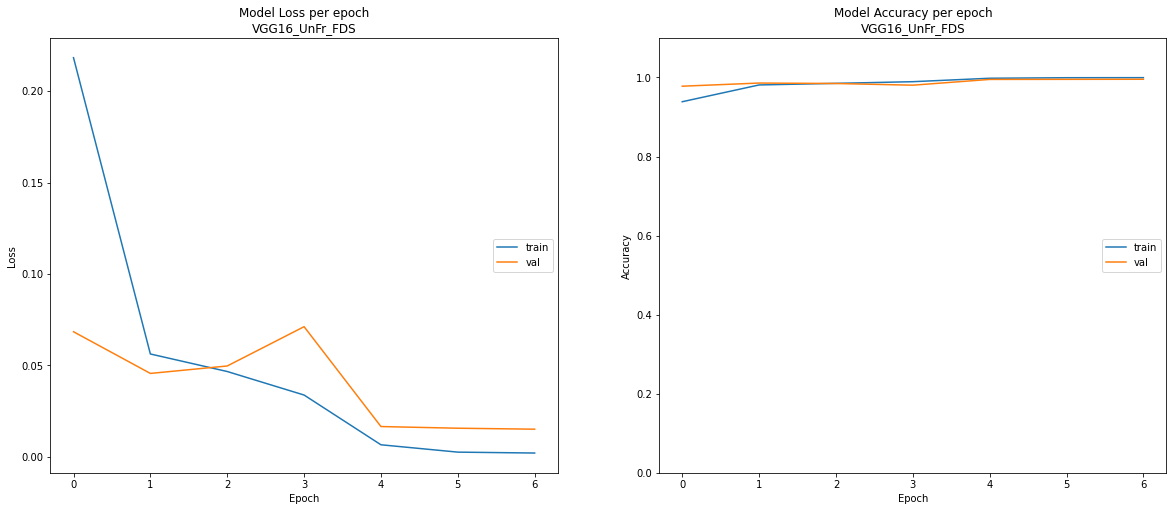

In [ ]:
# define starting learning rate
learn_rate = 0.001

# define optimizer
opt = keras.optimizers.Adam(learning_rate=learn_rate)

# define number of epochs
epochs = 20

# Finalize ModelCheckpoint
model_checkpoint_callback = check_point(checkpoint_filepath)

# compile model
model_VGG16.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
model_VGG16_history = model_VGG16.fit(train_gen, validation_data = valid_gen, epochs = epochs,
                                                callbacks=[model_checkpoint_callback, lrScheduler, early_stopping, reducelrplateau])

# save the model
model_VGG16.save(model_save_dir+model_name_to_save)


graph(model_VGG16_history,text_for_chart,)

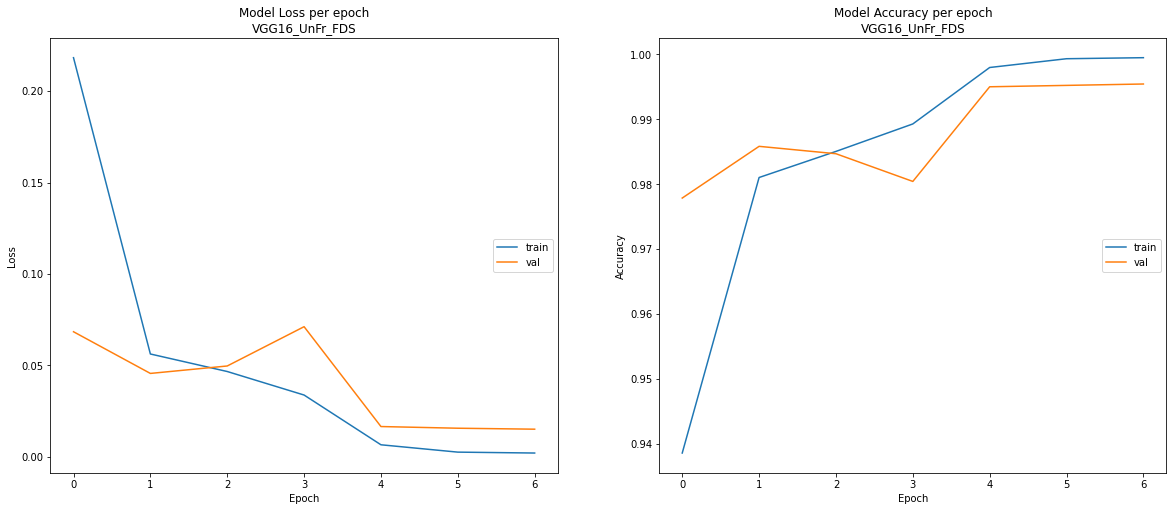

In [ ]:
graph(model_VGG16_history,text_for_chart,0)

##### Predictions and Analysis of Results

In [ ]:
### PREDICTIONS ####

#TRANSFORM TEST DATASET IN NUMPY OBJECT #
import tensorflow_datasets as tfds
ds_numpy = tfds.as_numpy(test_gen)

predictions = np.array([])
labels =  np.array([])

import progressbar
bar = progressbar.ProgressBar(maxval=17571/512, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
n=0
for x in ds_numpy:
  predictions = np.concatenate([predictions, np.argmax(model_VGG16.predict(x[-2]), axis=-1)])
  labels = np.concatenate([labels, np.argmax(x[-1], axis=-1)])
  bar.update(n)
  n+=1
bar.finish()


In [ ]:
print(classification_report(labels, predictions, digits = 3))

              precision    recall  f1-score   support

         0.0      0.998     0.994     0.996       504
         1.0      0.996     0.998     0.997       496
         2.0      0.995     1.000     0.998       440
         3.0      0.998     1.000     0.999       502
         4.0      0.998     0.996     0.997       454
         5.0      1.000     0.998     0.999       421
         6.0      0.998     1.000     0.999       456
         7.0      0.983     0.966     0.974       410
         8.0      0.998     0.998     0.998       477
         9.0      0.969     0.983     0.976       477
        10.0      1.000     1.000     1.000       465
        11.0      0.998     1.000     0.999       472
        12.0      1.000     1.000     1.000       480
        13.0      1.000     1.000     1.000       430
        14.0      0.998     1.000     0.999       423
        15.0      1.000     1.000     1.000       503
        16.0      0.998     0.989     0.993       459
        17.0      0.998    

In [ ]:
### Classification Report  ####

# If it's a loaded model leave third parameter empty (or set equal to None) 
classif_report(labels,predictions,) ## for loaded model
#classif_report(labels,predictions,model_history=model_history) ## for live trained model




              precision    recall  f1-score   support

         0.0      0.998     0.994     0.996       504
         1.0      0.996     0.998     0.997       496
         2.0      0.995     1.000     0.998       440
         3.0      0.998     1.000     0.999       502
         4.0      0.998     0.996     0.997       454
         5.0      1.000     0.998     0.999       421
         6.0      0.998     1.000     0.999       456
         7.0      0.983     0.966     0.974       410
         8.0      0.998     0.998     0.998       477
         9.0      0.969     0.983     0.976       477
        10.0      1.000     1.000     1.000       465
        11.0      0.998     1.000     0.999       472
        12.0      1.000     1.000     1.000       480
        13.0      1.000     1.000     1.000       430
        14.0      0.998     1.000     0.999       423
        15.0      1.000     1.000     1.000       503
        16.0      0.998     0.989     0.993       459
        17.0      0.998    

<Figure size 1440x360 with 0 Axes>

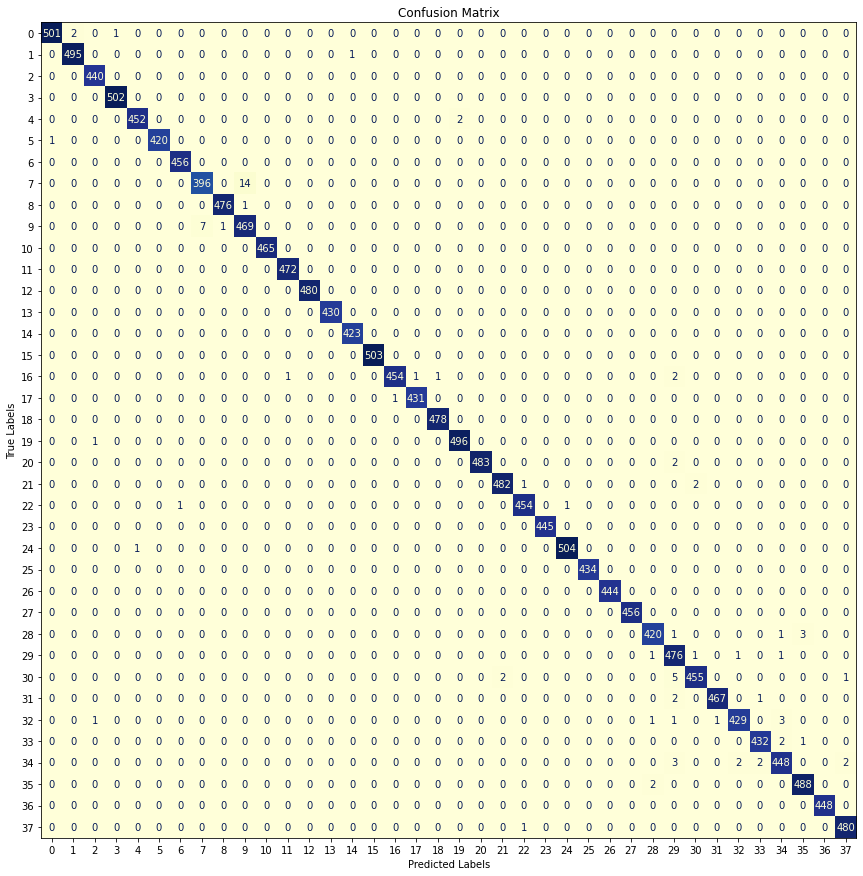

In [ ]:
  ### CONFUSION MATRIX ####
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
num_class = 38
conf_matrix(labels,predictions,num_class)

The overall results are quite impressive, suggesting that the overall dataset is too good to be true or could be not enough diversified. Accuracy in both training and test is around 99.5% (versus a training accuracy close to 100%). Also, the F1-score by class shows good results across all classes. At this level of results, it’s difficult to talk about difficulties in classifying specific classes. We can only note that if we try to identify classes on which the model is a bit less performant, again we identify class 7, 9,29 and 34.

### Transfer Learning : ResNet50



#### Presentation


ResNet (Residual Networks) is an innovative neural network that was first introduced in 2015 by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun

The key idea of ResNet was the introduction of “Shortcut Connections” and “Residual Learning”.  A Shortcut Connection is a direct connection that skips over some layers of the model. 

Residual learning is applied with shortcut connections from a block to the following one. When the input and output dimensions are the same, the shortcut connection performs identity shortcuts. When the dimensions of input and output are different, the shortcut connection performs projection shortcuts: the dimension is matched by dimension reduction and dimension elevation through a 1 × 1 convolution layer. 

Shortcut connection enables having a deeper network and finally ResNet became the Winner of ILSVRC 2015 in image classification, detection, and localization, as well as Winner of MS COCO 2015 detection, and segmentation. 

ResNet-50 is the 50 layers deep version of ResNet.


#### Definition and preprocessing of Train, Validation and Test sets
 Train and Validation are obtained splitting the Train Dataset

In [ ]:
# Define Batch Size and image size
batch_size =  128 
img_height = 256
img_width = 256 


# Split the contents of the folder "train" in Training and Validation Set 

# Training dataset => 80% of the original training dataset 
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,  
  subset="training", 
  label_mode = 'categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Validation dataset => 20% of the original training dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train, 
  validation_split=0.2, 
  subset="validation", 
  label_mode = 'categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


# Test Set 

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size= 512)# we use a bigger batch size for test dataset to speed up testing, 
  # better using the hardware. It shouldn't make any difference on test results



# Preprocessing and generation of train_gen, valid_gen, test_gen
# We use the specific preprocess, adapted to ResNet50 mode
from tensorflow.keras.applications.resnet50 import preprocess_input
train_gen = train_ds.map(lambda image,label:(preprocess_input(image/1.),label))
valid_gen  = val_ds.map(lambda image,label:(preprocess_input(image/1.),label))
test_gen = test_ds.map(lambda image,label:(preprocess_input(image/1.),label))







Found 70295 files belonging to 38 classes.
Using 56236 files for training.
Found 70295 files belonging to 38 classes.
Using 14059 files for validation.
Found 17571 files belonging to 38 classes.


#### Instantiation of the Model

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D

n_class=38

base_model = ResNet50(weights='imagenet', include_top=False,
                     classes= n_class,input_shape = (img_height, img_width, 3))


# Freeze the layers of base_model
for layer in base_model.layers: 
    layer.trainable = False

# We add our model over the base model
model_50 = Sequential()

model_50.add(base_model)

model_50.add(GlobalAveragePooling2D()) 
model_50.add(Dense(1024,activation='relu'))
model_50.add(Dropout(rate=0.2))
model_50.add(Dense(512, activation='relu'))
model_50.add(Dropout(rate=0.2))
model_50.add(Dense(n_class, activation='softmax'))

# Show base model(inception) summary
print(base_model.summary())

# Show our transfer model summary
print(model_50.summary())

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

#### ResNet50 Freezed

##### Definition of Names

In [ ]:
### DEFINE NAMES ###

model_name = 'RN50_Fr_FDS_July10'

# define the name for saving the model
model_name_to_save = model_name+'.h5'

# define the full path (including the name) for saving teh checkpoints 
checkpoint_filepath = 'gdrive/My Drive/New Plant Diseases/checkpoints/'+model_name+'.{epoch:03d}.h5'

# To be filled in the second part (WE MAY NEED TO DISCUSS A POSSIBLE STANDARD)
text_for_chart = model_name



##### Definition of the Callbacks (ResNet Freeze)

In [ ]:
### DEFINE THE CALLBACKS ###
# Callbacks allow us to apply functions at given stages of the training procedure.

from tensorflow.keras import callbacks

# ModelCheckpoint => saves the model after every epoch
def check_point(checkpoint_filepath):
    return callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=False, # the whole model is saved
      monitor='val_loss', # Metric monitored : validation loss
      mode='min', # Decision to overwrite the current save file based on the minimization of val_loss
      save_best_only=True) # Only saves when model considered the "best". Latest best model according to the quantity monitored will not be overwritten (save_best_only=True)


# LearningRateScheduler => Gets updated learning rate value at the beginning of every epoch, and applies the updated learning rate on the optimizer.
def decreasinglrUpdate(epoch,learning_rate):
    if epoch % 5 == 0:
        return learning_rate * 0.2
    else: 
        return learning_rate

lrScheduler = callbacks.LearningRateScheduler(schedule=decreasinglrUpdate, verbose=1)


# EarlyStopping => stops training depending on loss to avoid overfitting. Criteria : min_delta OR patience
early_stopping = callbacks.EarlyStopping(
    monitor='loss', # quantity to be monitored
    min_delta=0.01, # if the difference in loss is less than 0.01
    restore_best_weights=True, # keeps the best weights when stopped
    patience=2, # after 2 epoch without improvement
    verbose = 1) # shows on which epoch the training has been stopped 

#ReduceLROnPlateau => reduce learning rate once learning stagnates:
  #  (factor=0.1)
reducelrplateau = callbacks.ReduceLROnPlateau(
    monitor="val_loss", #quantity to be monitored
    factor=0.1, # reduction by a factor of 10 (new_lr = lr * factor)
    patience=2, # if no improvement is seen after 2 epoch
    verbose=1, # update messages
    mode="auto", # the direction (monitored quantity stopped decreasing/increasing) is automatically inferred from the name of the monitored quantity.
    min_delta=0.01, # threshold for measuring the new optimum
    cooldown=2)  # 2 epochs wait before resuming normal operation after learning rate has been reduced.

##### Training and saving the trained model


Epoch 1: LearningRateScheduler setting learning rate to 0.00020000000949949026.
Epoch 1/20
440/440 [==============================] - 4220s 9s/step - loss: 0.4564 - accuracy: 0.8746 - val_loss: 0.0965 - val_accuracy: 0.9711 - lr: 2.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00020000000949949026.
Epoch 2/20
440/440 [==============================] - 259s 585ms/step - loss: 0.1027 - accuracy: 0.9688 - val_loss: 0.0712 - val_accuracy: 0.9769 - lr: 2.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00020000000949949026.
Epoch 3/20
440/440 [==============================] - 258s 584ms/step - loss: 0.0648 - accuracy: 0.9798 - val_loss: 0.0482 - val_accuracy: 0.9844 - lr: 2.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00020000000949949026.
Epoch 4/20
440/440 [==============================] - 259s 584ms/step - loss: 0.0445 - accuracy: 0.9857 - val_loss: 0.0427 - val_accuracy: 0.9869 - lr: 2.0000e-04

Epoch 5: LearningRateSche

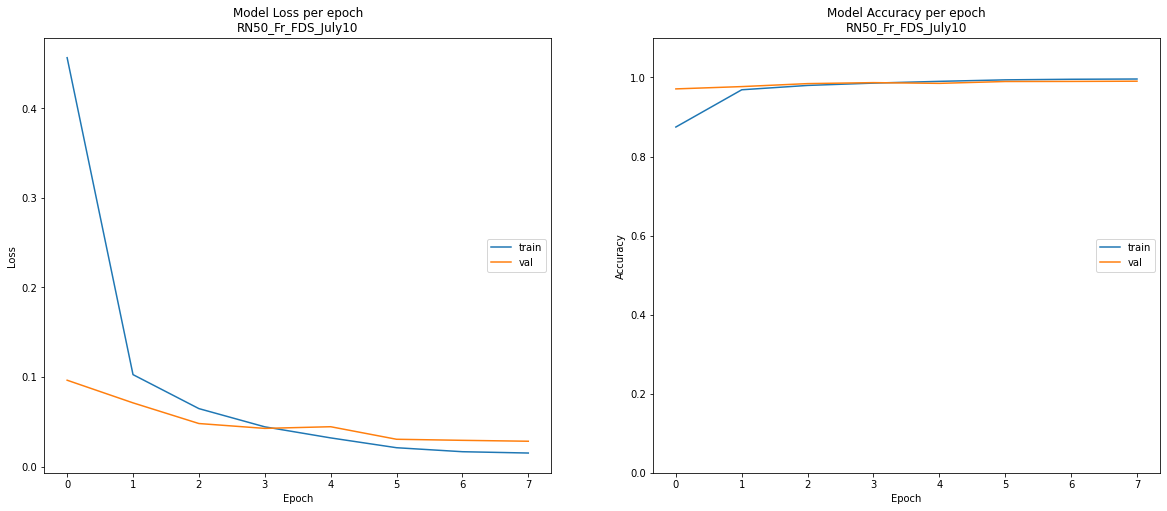

In [ ]:
# define starting learning rate
learn_rate = 0.001

# define optimizer
opt = keras.optimizers.Adam(learning_rate=learn_rate)

# define number of epochs
epochs = 20

# Finalize ModelCheckpoint
model_checkpoint_callback = check_point(checkpoint_filepath)

# compile model
model_50.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
model_50_history = model_50.fit(train_gen, validation_data = valid_gen, epochs = epochs,
                                                callbacks=[model_checkpoint_callback,lrScheduler, early_stopping, reducelrplateau])
                                                #callbacks=[model_checkpoint_callback, lrScheduler, early_stopping, reducelrplateau])

# save the model
model_50.save(model_save_dir+model_name_to_save)


graph(model_50_history,text_for_chart,)

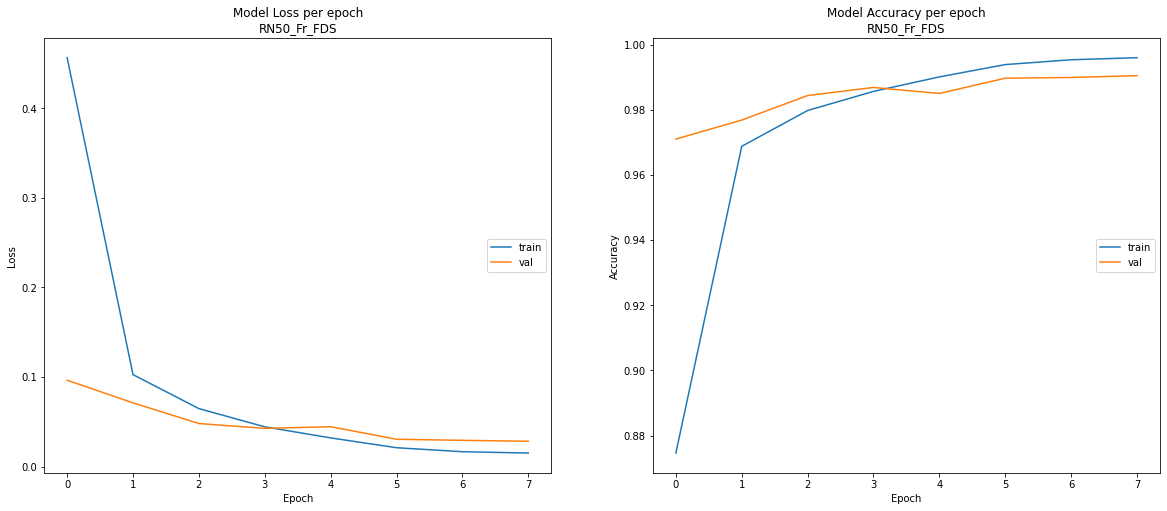

In [ ]:
graph(model_50_history,'RN50_Fr_FDS',0)

##### Loading of a trained model (alternative to train) 

In [ ]:
### THIS PART IS ALTERNATIVE TO TRAIN ###
# delete the variable model if it exists
if 'model_50' in locals(): 
  del model_50

model_name_to_load = 'RN50_Fr_FDS_July10.h5'
# load the model
model_50= keras.models.load_model(model_save_dir+model_name_to_load)

##### Predictions and Analysis of Results

In [ ]:
### PREDICTIONS ####

#TRANSFORM TEST DATASET IN NUMPY OBJECT #
import tensorflow_datasets as tfds
ds_numpy = tfds.as_numpy(test_gen)

predictions = np.array([])
labels =  np.array([])

import progressbar
bar = progressbar.ProgressBar(maxval=17571/512, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
n=0
for x in ds_numpy:
  predictions = np.concatenate([predictions, np.argmax(model_50.predict(x[-2]), axis=-1)])
  labels = np.concatenate([labels, np.argmax(x[-1], axis=-1)])
  bar.update(n)
  n+=1
bar.finish()


In [ ]:
### Classification Report  ####

# If it's a loaded model leave third parameter empty (or set equal to None) 
#classif_report(labels,predictions,) ## for loaded model
classif_report(labels,predictions,model_history=model_50_history) ## for live trained model




              precision    recall  f1-score   support

         0.0      0.992     0.990     0.991       504
         1.0      0.994     0.994     0.994       496
         2.0      0.995     1.000     0.998       440
         3.0      0.992     0.998     0.995       502
         4.0      0.996     1.000     0.998       454
         5.0      0.998     0.998     0.998       421
         6.0      1.000     0.998     0.999       456
         7.0      0.970     0.937     0.953       410
         8.0      0.998     0.996     0.997       477
         9.0      0.945     0.975     0.960       477
        10.0      1.000     1.000     1.000       465
        11.0      0.994     0.996     0.995       472
        12.0      0.996     0.994     0.995       480
        13.0      1.000     1.000     1.000       430
        14.0      1.000     0.998     0.999       423
        15.0      1.000     0.998     0.999       503
        16.0      0.998     0.991     0.995       459
        17.0      0.993    

In [ ]:
print(classification_report(labels, predictions, digits = 3))

              precision    recall  f1-score   support

         0.0      0.992     0.990     0.991       504
         1.0      0.994     0.994     0.994       496
         2.0      0.995     1.000     0.998       440
         3.0      0.992     0.998     0.995       502
         4.0      0.996     1.000     0.998       454
         5.0      0.998     0.998     0.998       421
         6.0      1.000     0.998     0.999       456
         7.0      0.970     0.937     0.953       410
         8.0      0.998     0.996     0.997       477
         9.0      0.945     0.975     0.960       477
        10.0      1.000     1.000     1.000       465
        11.0      0.994     0.996     0.995       472
        12.0      0.996     0.994     0.995       480
        13.0      1.000     1.000     1.000       430
        14.0      1.000     0.998     0.999       423
        15.0      1.000     0.998     0.999       503
        16.0      0.998     0.991     0.995       459
        17.0      0.993    

<Figure size 1440x360 with 0 Axes>

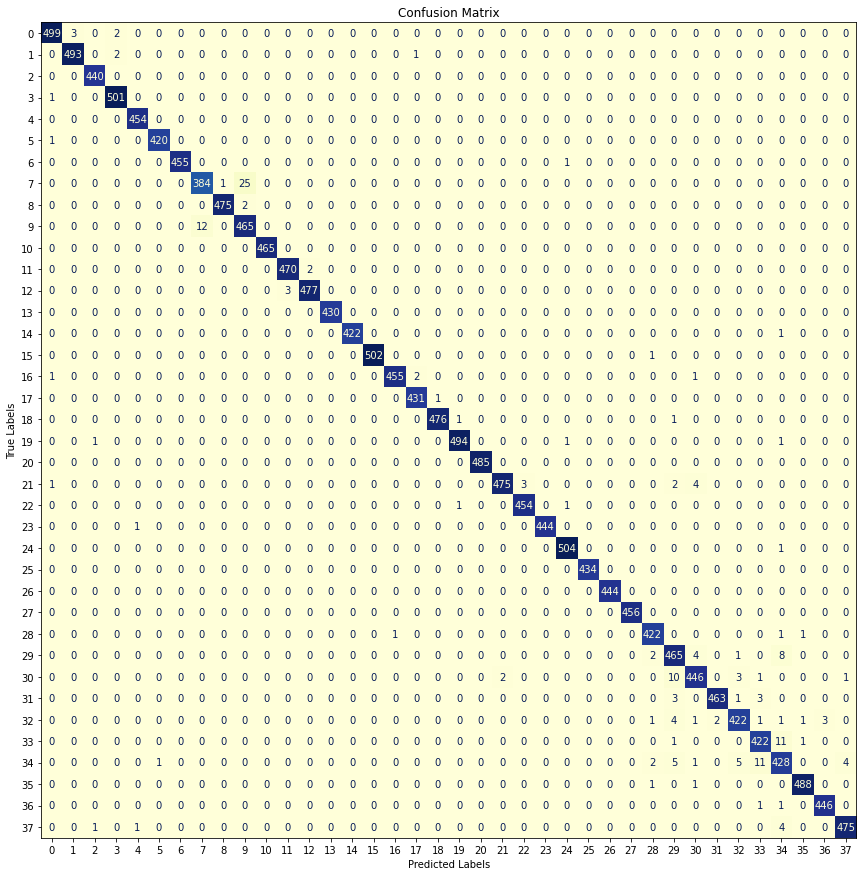

In [ ]:
  ### CONFUSION MATRIX ####
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
num_class = 38
conf_matrix(labels,predictions,num_class)

In terms of single classes, we have a behavior like the previously tested models: the F1-score by class shows that the model struggles in classifying Class 7 and 9 (both related to corn’s leaves) and the classes from 28 to 37 (the ones related to tomato’s leaves), with class 34 resulting the most difficult to classify of the whole dataset.  The Confusion Matrix shows that the model sometime inverts Class 7 and 9, while for the tomato’s leaves there is more dispersion of misclassification among the various classes. 
The overall results are overall quite good with an accuracy in both training and test close to 99% and a training accuracy only 0.6% higher (very limited overfitting). 


#### Unfreezing ResNet50
In the first tests with unfreezing ResNet50 the results were not really satisfying: the training was stopped after only a few epochs with a validation accuracy in line with the one of the freezed model.

So here, compared to the freezes version, we apply a couple of  changes in the starting learning rate and the Callbacks:

- We decrease the starting learning rate to 0.0001;
- We remove the LearningRateScheduler as we already had a starting learning rate 10 times lower, and we also expected the ReduceLROnPlateau to be more active because we started from an already very performing model;
- We increase the patience of EarlingStopping to 4.


##### Load the freeze model 


In [ ]:
### LOAD THE FREEZE MODEL ###
# delete the variable model if it exists
if 'model_50' in locals(): 
  del model_50
model_name_to_load = 'RN50_Fr_FDS_July10.h5'
# load the model
model_50= keras.models.load_model(model_save_dir+model_name_to_load)

##### Definition of Names


In [ ]:
### DEFINE NAMES ###

model_name = 'RN50_UnFr10_FDS'

# define the name for saving the model
model_name_to_save = model_name+'.h5'

# define the full path (including the name) for saving the checkpoints 
checkpoint_filepath = 'gdrive/My Drive/New Plant Diseases/checkpoints/'+model_name+'.{epoch:03d}.h5'

# To be filled in the second part 
text_for_chart = model_name


##### Unfreezing the last 10 layers
###### This corresponds to  unfreezing the last “bottleneck” building block.

In [ ]:

for layer in model_50.layers:
    if "Functional" == layer.__class__.__name__:  
         #here you can iterate and choose the layers of your nested model
         for _layer in layer.layers[-10:]:
              # your logic with nested model layers
              _layer.trainable = True

In [ ]:
# SHOW THE UNFREEZE MODEL
print(model_50.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

##### Definition of the Callbacks (ResNet Unfreeze)

In [ ]:
### DEFINE THE CALLBACKS ###
# Callbacks allow us to apply functions at given stages of the training procedure.

from tensorflow.keras import callbacks

# ModelCheckpoint => saves the model after every epoch
def check_point(checkpoint_filepath):
    return callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=False, # the whole model is saved
      monitor='val_loss', # Metric monitored : validation loss
      mode='min', # Decision to overwrite the current save file based on the minimization of val_loss
      save_best_only=True) # Only saves when model considered the "best". Latest best model according to the quantity monitored will not be overwritten (save_best_only=True)


# LearningRateScheduler => Gets updated learning rate value at the beginning of every epoch, and applies the updated learning rate on the optimizer.
def decreasinglrUpdate(epoch,learning_rate):
    if epoch % 5 == 0:
        return learning_rate * 0.2
    else: 
        return learning_rate

lrScheduler = callbacks.LearningRateScheduler(schedule=decreasinglrUpdate, verbose=1)


# EarlyStopping => stops training depending on loss to avoid overfitting. Criteria : min_delta OR patience
early_stopping = callbacks.EarlyStopping(
    monitor='loss', # quantity to be monitored
    min_delta=0.01, # if the difference in loss is less than 0.01
    restore_best_weights=True, # keeps the best weights when stopped
    patience=4, # after 4 epoch without improvement
    verbose = 1) # shows on which epoch the training has been stopped 

#ReduceLROnPlateau => reduce learning rate once learning stagnates:
  #  (factor=0.1)
reducelrplateau = callbacks.ReduceLROnPlateau(
    monitor="val_loss", #quantity to be monitored
    factor=0.1, # reduction by a factor of 10 (new_lr = lr * factor)
    patience=2, # if no improvement is seen after 2 epoch
    verbose=1, # update messages
    mode="auto", # the direction (monitored quantity stopped decreasing/increasing) is automatically inferred from the name of the monitored quantity.
    min_delta=0.01, # threshold for measuring the new optimum
    cooldown=2)  # 2 epochs wait before resuming normal operation after learning rate has been reduced.

##### Training and saving the trained model

Epoch 1/20
440/440 [==============================] - 5003s 11s/step - loss: 0.0284 - accuracy: 0.9908 - val_loss: 0.0345 - val_accuracy: 0.9886 - lr: 1.0000e-04
Epoch 2/20
440/440 [==============================] - 158s 355ms/step - loss: 0.0143 - accuracy: 0.9953 - val_loss: 0.0295 - val_accuracy: 0.9905 - lr: 1.0000e-04
Epoch 3/20
440/440 [==============================] - ETA: 0s - loss: 0.0089 - accuracy: 0.9975
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
440/440 [==============================] - 156s 352ms/step - loss: 0.0089 - accuracy: 0.9975 - val_loss: 0.0338 - val_accuracy: 0.9888 - lr: 1.0000e-04
Epoch 4/20
440/440 [==============================] - 157s 353ms/step - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0.0182 - val_accuracy: 0.9941 - lr: 1.0000e-05
Epoch 5/20
440/440 [==============================] - 157s 352ms/step - loss: 0.0018 - accuracy: 0.9998 - val_loss: 0.0178 - val_accuracy: 0.9940 - lr: 1.0000e-05
Epoch 6/20
440/440 [=====

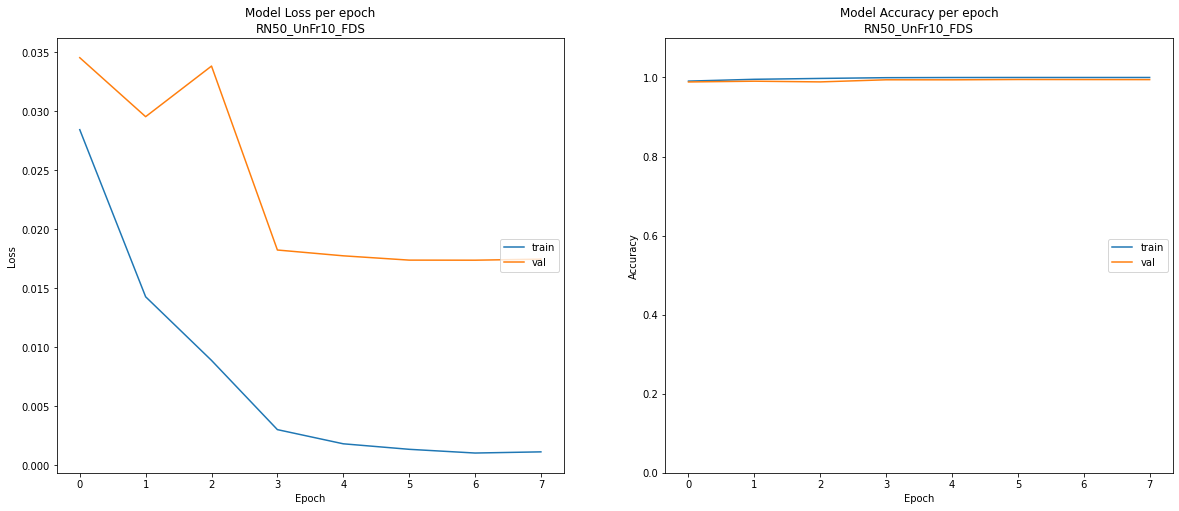

In [ ]:
# define starting learning rate
learn_rate = 0.0001 # we decreased the starting LTR for fine-tuning

# define optimizer
opt = keras.optimizers.Adam(learning_rate=learn_rate)

# define number of epochs
epochs = 20

# Finalize ModelCheckpoint
model_checkpoint_callback = check_point(checkpoint_filepath)

# compile model: we exclude the LearningRateScheduler 
#                as we already have a starting learning rate 10 times lower, 
#                and we expect the ReduceLROnPlateau to be more active

model_50.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
model_50_history = model_50.fit(train_gen, validation_data = valid_gen, epochs = epochs,
                                                callbacks=[model_checkpoint_callback,  early_stopping, reducelrplateau])
                                                #callbacks=[model_checkpoint_callback, lrScheduler, early_stopping, reducelrplateau])
# save the model
model_50.save(model_save_dir+model_name_to_save)


graph(model_50_history,text_for_chart,)

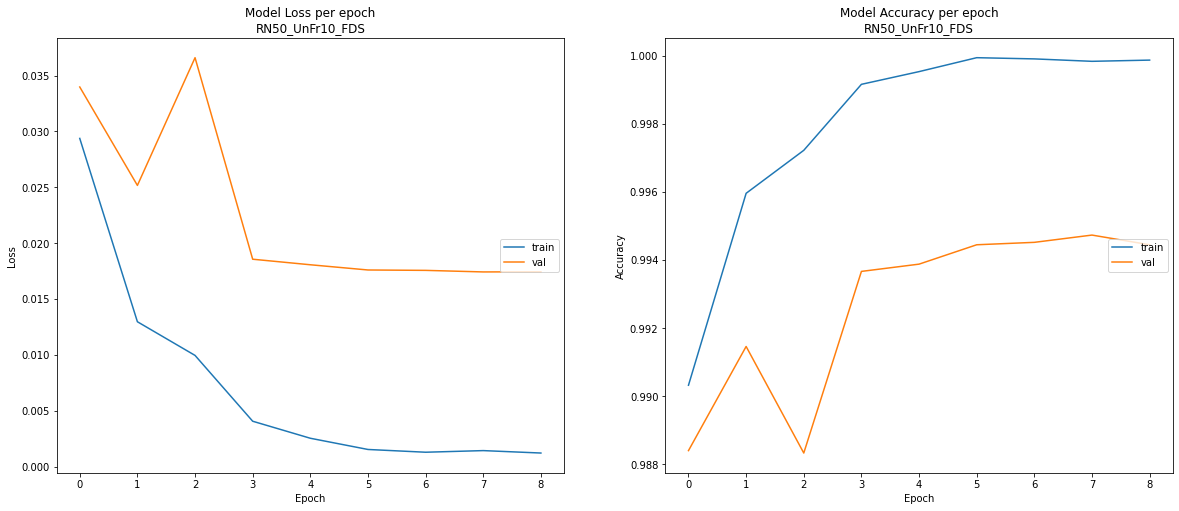

In [ ]:
graph(model_50_history,text_for_chart,0)

##### Predictions and Analysis of Results

In [ ]:
### PREDICTIONS ####

#TRANSFORM TEST DATASET IN NUMPY OBJECT #
import tensorflow_datasets as tfds
ds_numpy = tfds.as_numpy(test_gen)

predictions = np.array([])
labels =  np.array([])

import progressbar
bar = progressbar.ProgressBar(maxval=17571/512, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
n=0
for x in ds_numpy:
  predictions = np.concatenate([predictions, np.argmax(model_50.predict(x[-2]), axis=-1)])
  labels = np.concatenate([labels, np.argmax(x[-1], axis=-1)])
  bar.update(n)
  n+=1
bar.finish()


[========================================================================] 100%


In [ ]:
print(classification_report(labels, predictions, digits = 3))

              precision    recall  f1-score   support

         0.0      0.994     0.988     0.991       504
         1.0      0.994     0.996     0.995       496
         2.0      0.998     1.000     0.999       440
         3.0      0.996     0.998     0.997       502
         4.0      1.000     1.000     1.000       454
         5.0      0.998     1.000     0.999       421
         6.0      1.000     1.000     1.000       456
         7.0      0.975     0.954     0.964       410
         8.0      1.000     0.996     0.998       477
         9.0      0.959     0.981     0.970       477
        10.0      1.000     1.000     1.000       465
        11.0      0.998     0.998     0.998       472
        12.0      0.998     0.998     0.998       480
        13.0      1.000     1.000     1.000       430
        14.0      1.000     1.000     1.000       423
        15.0      1.000     1.000     1.000       503
        16.0      1.000     0.996     0.998       459
        17.0      0.995    

In [ ]:
### Classification Report  ####

# If it's a loaded model leave third parameter empty (or set equal to None) 
classif_report(labels,predictions,) ## for loaded model
#classif_report(labels,predictions,model_history=model_50_history) ## for live trained model




              precision    recall  f1-score   support

         0.0      0.994     0.988     0.991       504
         1.0      0.994     0.996     0.995       496
         2.0      0.998     1.000     0.999       440
         3.0      0.996     0.998     0.997       502
         4.0      1.000     1.000     1.000       454
         5.0      0.998     1.000     0.999       421
         6.0      1.000     1.000     1.000       456
         7.0      0.975     0.954     0.964       410
         8.0      1.000     0.996     0.998       477
         9.0      0.959     0.981     0.970       477
        10.0      1.000     1.000     1.000       465
        11.0      0.998     0.998     0.998       472
        12.0      0.998     0.998     0.998       480
        13.0      1.000     1.000     1.000       430
        14.0      1.000     1.000     1.000       423
        15.0      1.000     1.000     1.000       503
        16.0      1.000     0.996     0.998       459
        17.0      0.995    

<Figure size 1440x360 with 0 Axes>

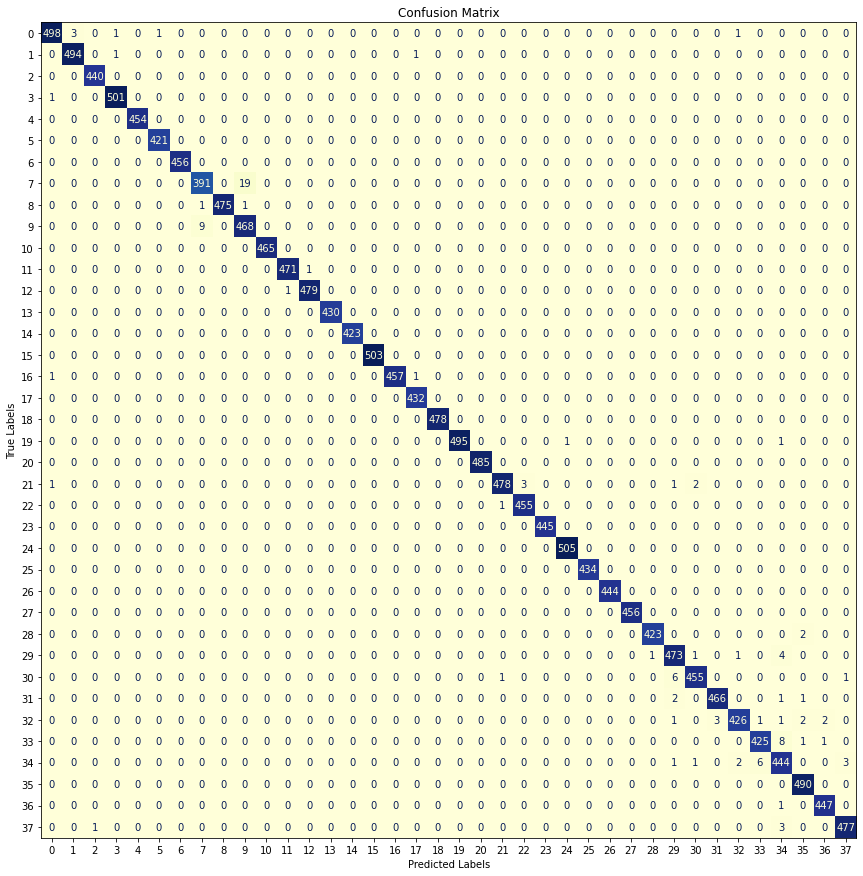

In [ ]:
  ### CONFUSION MATRIX ####
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
num_class = 38
conf_matrix(labels,predictions,num_class)

The overall results are very good, suggesting that the overall dataset is too good to be true or could be not enough diversified. Accuracy in both training and test is around 99.4% (versus a training accuracy close to 100%). Also, the F1-score by class shows good results across all classes. At this level of results, it’s difficult to talk about difficulties in classifying specific classes. We can only note that if we try to identify classes on which the model is a bit less performant, again we identify class 7, 9, 29 and 34

### Transfer Learning : Inception V3


#### Presentation


Inception v3 is an image recognition model that has been shown to attain greater than 78.1% accuracy on the ImageNet dataset. The model is the culmination of many ideas developed by multiple researchers over the years. It is based on the original paper: "Rethinking the Inception Architecture for Computer Vision" by Szegedy, et. al.

The model itself is made up of symmetric and asymmetric building blocks, including convolutions, average pooling, max pooling, concatenations, dropouts, and fully connected layers. Batch normalization is used extensively throughout the model and applied to activation inputs. Loss is computed using Softmax.

https://cloud.google.com/static/tpu/docs/images/inceptionv3onc--oview.png

#### Library


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3       #model
from tensorflow.keras.applications.inception_v3  import preprocess_input #preprocessing function

#### Definition and preprocessing of Train, Validation and Test sets

In [ ]:
# Define Batch Size and image size
batch_size =  128 
img_height = 256 
img_width = 256 

# Split the contents of the folder "train" in Training and Validation Set 
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  label_mode = 'categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  label_mode = 'categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=512)

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  label_mode = 'categorical',
  image_size=(img_height, img_width), 
  batch_size= 512)


# Transformation using the Inception V3 preprocessing function

train_gen_inception = train_ds.map(lambda image,label:(preprocess_input(image),label))
valid_gen_inception  = val_ds.map(lambda image,label:(preprocess_input(image),label))
test_gen_inception = test_ds.map(lambda image,label:(preprocess_input(image),label))

Found 70295 files belonging to 38 classes.
Using 56236 files for training.
Found 70295 files belonging to 38 classes.
Using 14059 files for validation.
Found 17571 files belonging to 38 classes.


#### Definition of  the Callbacks (Inception V3)


In [ ]:
### DEFINE THE CALLBACKS ###
# Callbacks allow us to apply functions at given stages of the training procedure.

from tensorflow.keras import callbacks

# ModelCheckpoint => saves the model after every epoch
def check_point(checkpoint_filepath):
    return callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True, # Only model weights are saved, not whole model
      monitor='val_accuracy', # Metric monitored : validation accuracy
      mode='max', # Decision to overwrite the current save file based on the maximization of val_accuracy
      save_best_only=True) # Only saves when model considered the "best". Latest best model according to the quantity monitored will not be overwritten (save_best_only=True)

# EarlyStopping => stops training depending on loss to avoid overfitting. Criteria : min_delta OR patience
early_stopping = callbacks.EarlyStopping(
    monitor='loss', # quantity to be monitored
    min_delta=0.01, # if the difference in loss is less than 0.01
    restore_best_weights=True, # keeps the best weights when stopped
    patience=1, # after 1 epoch without improvement
    verbose = 1) # shows on which epoch the training has been stopped 

#ReduceLROnPlateau => reduce learning rate once learning stagnates:
  #  (factor=0.1)
reducelrplateau = callbacks.ReduceLROnPlateau(
    monitor="val_loss", #quantity to be monitored
    factor=0.1, # reduction by a factor of 10 (new_lr = lr * factor)
    patience=1, # if no improvement is seen after 1 epoch
    verbose=1, # update messages
    mode="auto", # the direction (monitored quantity stopped decreasing/increasing) is automatically inferred from the name of the monitored quantity.
    min_delta=0.01, # threshold for measuring the new optimum
    cooldown=0)  # 0 epochs wait before resuming normal operation after learning rate has been reduced.

#### Instance the Model

In [ ]:
#The numuber of different classes
n_class=38

# Modèle Inception V3
#This model is freezed and weights are based on 'imagenet'.
base_model = InceptionV3(weights='imagenet', 
                         include_top=False,
                         classes= n_class,
                         input_shape = (img_height, img_width, 3))


# Free the layers of base_model
for layer in base_model.layers: 
    layer.trainable = False

#We can had some layers on the Inception model
model_Inception = Sequential()

model_Inception.add(base_model)

model_Inception.add(GlobalAveragePooling2D()) 
model_Inception.add(Dense(1024,activation='relu')) 
model_Inception.add(Dropout(rate=0.2))
model_Inception.add(Dense(512, activation='relu'))
model_Inception.add(Dropout(rate=0.2))
model_Inception.add(Dense(n_class, activation='softmax')) # softmax is the activation function recommanded

# Show base model(inception) summary
print(base_model.summary())

# Show our transfer learning model summary
print(model_Inception.summary())


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 127, 127, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 127, 127, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

#### Inception V3 Freezed

##### Definition of Names

In [ ]:
### DEFINE NAMES ###

model_name = 'INV3_Fr_FDS'

# define the name for saving the model
model_name_to_save = model_name+'.h5'

# define the full path (including the name) for saving the checkpoints 
checkpoint_filepath = 'gdrive/My Drive/New Plant Diseases/checkpoints/'+model_name+'.{epoch:03d}.h5'

# To be filled in the second part 
text_for_chart = model_name

##### Training and saving the trained model

Epoch 1/20
440/440 [==============================] - 123s 262ms/step - loss: 0.7350 - accuracy: 0.7724 - val_loss: 0.3107 - val_accuracy: 0.8954 - lr: 0.0010
Epoch 2/20
440/440 [==============================] - ETA: 0s - loss: 0.3541 - accuracy: 0.8829
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
440/440 [==============================] - 110s 248ms/step - loss: 0.3541 - accuracy: 0.8829 - val_loss: 0.3127 - val_accuracy: 0.8964 - lr: 0.0010
Epoch 3/20
440/440 [==============================] - 110s 248ms/step - loss: 0.1932 - accuracy: 0.9348 - val_loss: 0.1930 - val_accuracy: 0.9349 - lr: 1.0000e-04
Epoch 4/20
440/440 [==============================] - ETA: 0s - loss: 0.1677 - accuracy: 0.9440
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
440/440 [==============================] - 111s 249ms/step - loss: 0.1677 - accuracy: 0.9440 - val_loss: 0.1835 - val_accuracy: 0.9380 - lr: 1.0000e-04
Epoch 5/20
440/440 [============

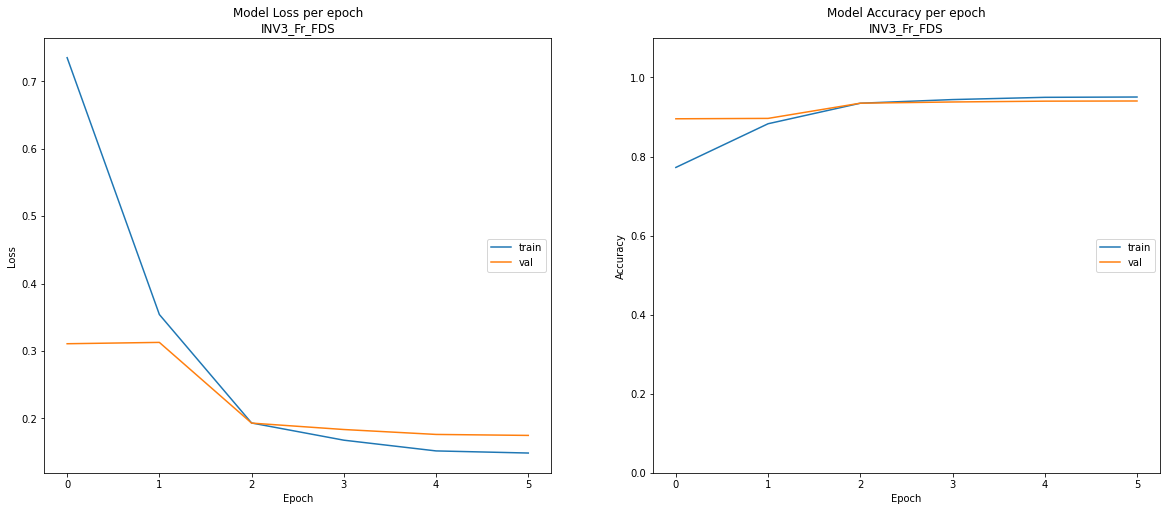

In [ ]:
# define starting learning rate
learn_rate = 0.001

# define optimizer
opt = keras.optimizers.Adam(learning_rate=learn_rate)

# define number of epochs
epochs = 20

# Finalize ModelCheckpoint
model_checkpoint_callback = check_point(checkpoint_filepath)

# compile model

model_Inception.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
model_Inception_history = model_Inception.fit(train_gen_inception,
                                              validation_data = valid_gen_inception,
                                              epochs = epochs,
                                              callbacks = [model_checkpoint_callback, 
                                                           early_stopping, 
                                                           reducelrplateau])


# save the model
model_Inception.save(model_save_dir+model_name_to_save)

graph(model_Inception_history,text_for_chart,)

##### Loading of a trained model (alternative to train) 

In [ ]:
### THIS PART IS ALTERNATIVE TO TRAIN ###
#model_name_to_load = 'INV3_Fr_FDS.h5'
#load the model
#model_Inception= keras.models.load_model(model_save_dir+model_name_to_load)

##### Predictions and Analysis of Results

In [ ]:
### Predictions ####

#Transform Dataset in TRANSFORM TEST DATASET IN NUMPY OBJECT #
import tensorflow_datasets as tfds
ds_numpy = tfds.as_numpy(test_gen_inception)

predictions_inception = np.array([])
labels_inception =  np.array([])


for x in ds_numpy:
  predictions_inception = np.concatenate([predictions_inception, np.argmax(model_Inception.predict(x[-2]), axis=-1)])
  labels_inception = np.concatenate([labels_inception, np.argmax(x[-1], axis=-1)])

In [ ]:
### Classification Report  ####

# If it's a loaded model leave third parameter empty (or set equl to None) 
#classif_report(labels,predictions,) ## for loaded model
classif_report(labels_inception, predictions_inception, model_history = model_Inception_history) ## for live trained model



              precision    recall  f1-score   support

         0.0      0.954     0.948     0.951       504
         1.0      0.976     0.988     0.982       496
         2.0      0.966     0.973     0.969       440
         3.0      0.932     0.948     0.940       502
         4.0      0.968     0.985     0.976       454
         5.0      0.990     0.990     0.990       421
         6.0      0.983     0.991     0.987       456
         7.0      0.939     0.871     0.904       410
         8.0      0.985     0.987     0.986       477
         9.0      0.897     0.952     0.924       477
        10.0      0.991     0.996     0.994       465
        11.0      0.970     0.951     0.960       472
        12.0      0.955     0.971     0.963       480
        13.0      0.988     0.991     0.990       430
        14.0      1.000     0.998     0.999       423
        15.0      0.992     0.990     0.991       503
        16.0      0.976     0.965     0.970       459
        17.0      0.975    

<Figure size 1440x360 with 0 Axes>

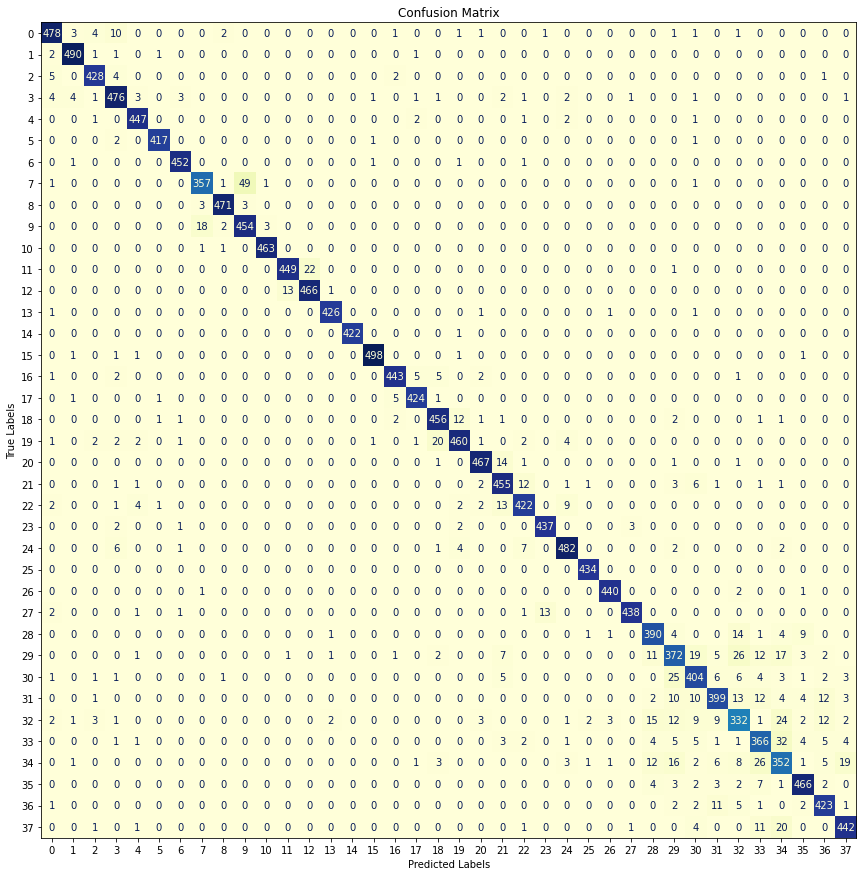

In [ ]:
  ### CONFUSION MATRIX ####
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
num_class = 38
conf_matrix(labels_inception, predictions_inception, num_class)

#### Let's unfreezed Inception V3

We tried to unfreezed different layers in order to increase the accuracy.

In [ ]:
# We load the model to use previous calculation
model_Inception_test = model_Inception 

In [ ]:
### LOAD THE FREEZE MODEL ###
model_name_to_load = 'INV3_Fr_FDS.h5'
# load the model
model_Inception_test= keras.models.load_model(model_save_dir+model_name_to_load)

##### Unfreezed 12 layers

###### Definition of Names


In [ ]:
### DEFINE NAMES ###

model_name = 'INV3_UnFr12_FDS'

# define the name for saving the model
model_name_to_save = model_name+'.h5'

# define the full path (including the name) for saving teh checkpoints 
checkpoint_filepath = 'gdrive/My Drive/New Plant Diseases/checkpoints/'+model_name+'.{epoch:03d}.h5'

# To be filled in the second part 
text_for_chart = model_name

###### Training and saving the model


In [ ]:
# define number of epochs
epochs = 20

# Finalize ModelCheckpoint
model_checkpoint_callback = check_point(checkpoint_filepath)

for layer in model_Inception_test.layers:
    if "Functional" == layer.__class__.__name__:  
         #here you can iterate and choose the layers of your nested model
         for _layer in layer.layers[-12:]: # unfreezed 12 layers on the last conv layers
              # your logic with nested model layers
              _layer.trainable = True


#Compile the model
opt = keras.optimizers.Adam(learning_rate=0.001)

model_Inception_test.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
model_Inception_test_history = model_Inception_test.fit(train_gen_inception,
                                              validation_data = valid_gen_inception,
                                              epochs = epochs,
                                              callbacks = [model_checkpoint_callback, 
                                                           early_stopping, 
                                                           reducelrplateau])

Epoch 1/20
440/440 [==============================] - 4189s 9s/step - loss: 0.2376 - accuracy: 0.9197 - val_loss: 0.1569 - val_accuracy: 0.9473 - lr: 0.0010
Epoch 2/20
440/440 [==============================] - ETA: 0s - loss: 0.1441 - accuracy: 0.9520
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
440/440 [==============================] - 188s 426ms/step - loss: 0.1441 - accuracy: 0.9520 - val_loss: 0.1563 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 3/20
440/440 [==============================] - 188s 426ms/step - loss: 0.0567 - accuracy: 0.9809 - val_loss: 0.0893 - val_accuracy: 0.9711 - lr: 1.0000e-04
Epoch 4/20
440/440 [==============================] - ETA: 0s - loss: 0.0381 - accuracy: 0.9875
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
440/440 [==============================] - 189s 426ms/step - loss: 0.0381 - accuracy: 0.9875 - val_loss: 0.0851 - val_accuracy: 0.9730 - lr: 1.0000e-04
Epoch 5/20
440/440 [==============

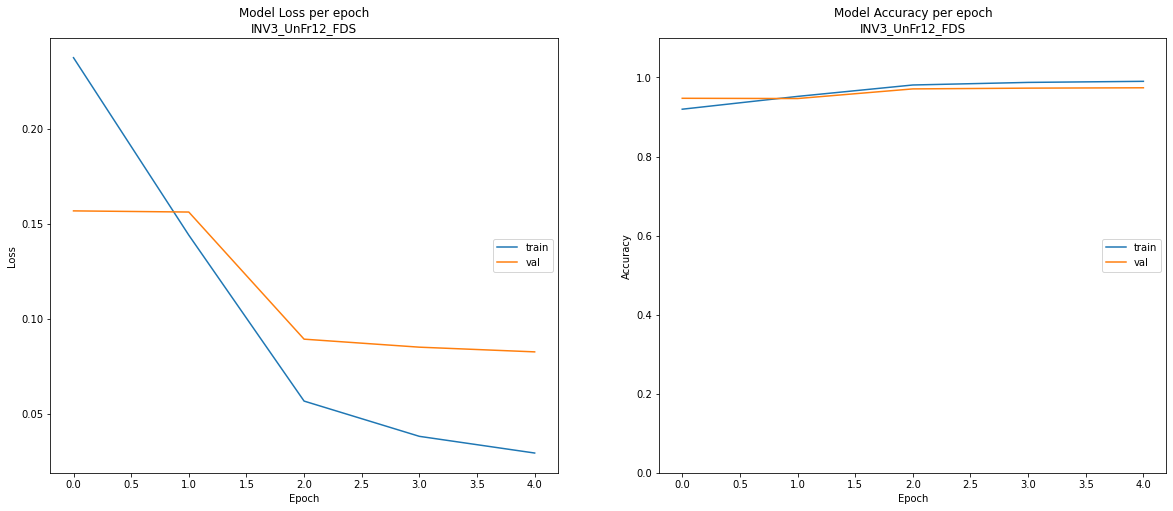

In [ ]:
graph(model_Inception_test_history,text_for_chart,)

In [ ]:
# save the model
model_Inception_test.save(model_save_dir+model_name_to_save)

###### Predictions and Analysis of Results

In [ ]:
### LOAD THE UNFREEZE MODEL ###
if 'model_Inception_test' in locals(): 
  del model_Inception_test
  
model_name_to_load = 'INV3_UnFr12_FDS.h5'
# load the model
model_Inception_test= keras.models.load_model(model_save_dir+model_name_to_load)

In [ ]:

print(model_Inception_test.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

In [ ]:
### Predictions ####

#Transform Dataset in TRANSFORM TEST DATASET IN NUMPY OBJECT #
import tensorflow_datasets as tfds
ds_numpy = tfds.as_numpy(test_gen_inception)

predictions_inception = np.array([])
labels_inception =  np.array([])


for x in ds_numpy:
  predictions_inception = np.concatenate([predictions_inception, np.argmax(model_Inception_test.predict(x[-2]), axis=-1)])
  labels_inception = np.concatenate([labels_inception, np.argmax(x[-1], axis=-1)])

In [ ]:
print(classification_report(labels_inception,   predictions_inception, digits = 3))

              precision    recall  f1-score   support

         0.0      0.992     0.976     0.984       504
         1.0      0.984     0.998     0.991       496
         2.0      0.982     0.989     0.985       440
         3.0      0.976     0.982     0.979       502
         4.0      0.987     0.991     0.989       454
         5.0      0.993     0.995     0.994       421
         6.0      0.993     0.996     0.995       456
         7.0      0.956     0.902     0.928       410
         8.0      0.996     0.994     0.995       477
         9.0      0.920     0.966     0.943       477
        10.0      0.996     0.996     0.996       465
        11.0      0.969     0.981     0.975       472
        12.0      0.981     0.971     0.976       480
        13.0      0.998     0.995     0.997       430
        14.0      1.000     1.000     1.000       423
        15.0      0.998     0.998     0.998       503
        16.0      0.989     0.991     0.990       459
        17.0      0.986    

In [ ]:
### Classification Report  ####

# If it's a loaded model leave third parameter empty (or set equal to None) 
classif_report(labels_inception,predictions_inception,) ## for loaded model
#classif_report(labels_inception,predictions_inception,model_history=model_history) ## for live trained model




              precision    recall  f1-score   support

         0.0      0.992     0.976     0.984       504
         1.0      0.984     0.998     0.991       496
         2.0      0.982     0.989     0.985       440
         3.0      0.976     0.982     0.979       502
         4.0      0.987     0.991     0.989       454
         5.0      0.993     0.995     0.994       421
         6.0      0.993     0.996     0.995       456
         7.0      0.956     0.902     0.928       410
         8.0      0.996     0.994     0.995       477
         9.0      0.920     0.966     0.943       477
        10.0      0.996     0.996     0.996       465
        11.0      0.969     0.981     0.975       472
        12.0      0.981     0.971     0.976       480
        13.0      0.998     0.995     0.997       430
        14.0      1.000     1.000     1.000       423
        15.0      0.998     0.998     0.998       503
        16.0      0.989     0.991     0.990       459
        17.0      0.986    

<Figure size 1440x360 with 0 Axes>

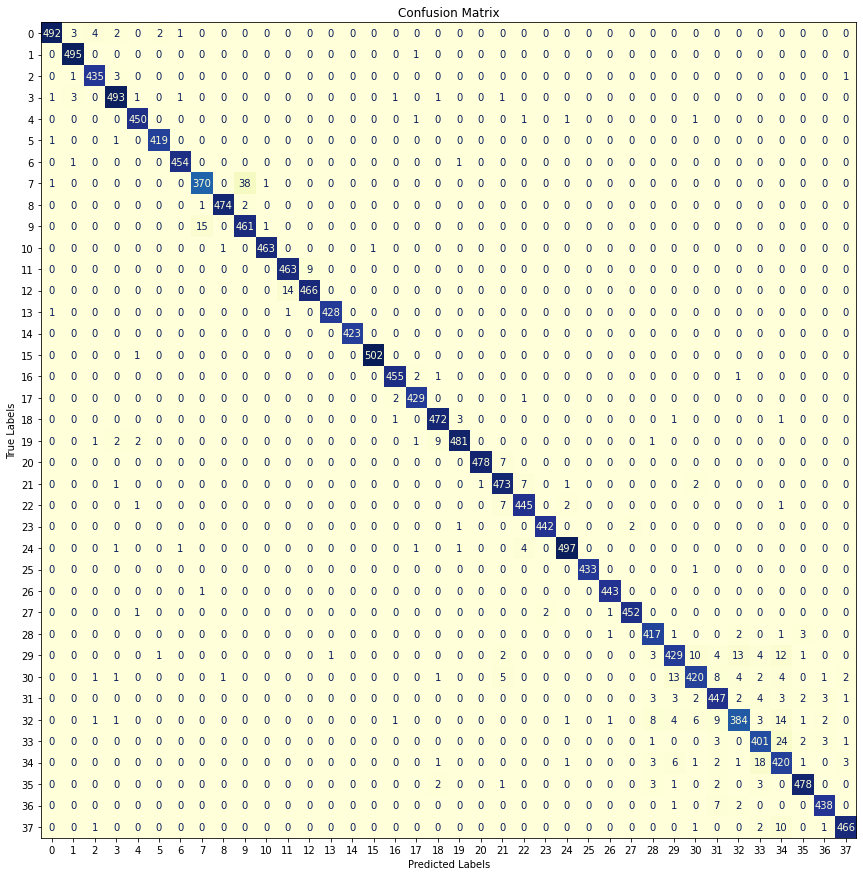

In [ ]:
  ### CONFUSION MATRIX ####
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
num_class = 38
conf_matrix(labels_inception,predictions_inception,num_class)

##### Unfreezed 23 layers

###### Definition of Names


In [ ]:
### DEFINE NAMES ###

model_name = 'INV3_UnFr23_FDS'

# define the name for saving the model
model_name_to_save = model_name+'.h5'

# define the full path (including the name) for saving teh checkpoints 
checkpoint_filepath = 'gdrive/My Drive/New Plant Diseases/checkpoints/'+model_name+'.{epoch:03d}.h5'

# To be filled in the second part 
text_for_chart = model_name

###### Training and saving the model


In [ ]:
### LOAD THE FREEZE MODEL ###
model_name_to_load = 'INV3_Fr_FDS.h5'
# load the model
model_Inception_test_23 = keras.models.load_model(model_save_dir+model_name_to_load)

In [ ]:
# define number of epochs
epochs = 20

# Finalize ModelCheckpoint
model_checkpoint_callback = check_point(checkpoint_filepath)

for layer in model_Inception_test_23.layers:
    if "Functional" == layer.__class__.__name__:  
         #here you can iterate and choose the layers of your nested model
         for _layer in layer.layers[-23:]: # unfreezed 23 layers before several conv layers 
              # your logic with nested model layers
              _layer.trainable = True


#Compile the model

# We compile the model
opt = keras.optimizers.Adam(learning_rate=0.001)
model_Inception_test_23.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
model_Inception_test_23_history = model_Inception_test_23.fit(train_gen_inception,
                                              validation_data = valid_gen_inception,
                                              epochs = epochs,
                                              callbacks = [model_checkpoint_callback, 
                                                           early_stopping, 
                                                           reducelrplateau])

Epoch 1/20
440/440 [==============================] - 206s 458ms/step - loss: 0.2602 - accuracy: 0.9153 - val_loss: 0.2187 - val_accuracy: 0.9317 - lr: 0.0010
Epoch 2/20
440/440 [==============================] - 197s 445ms/step - loss: 0.1200 - accuracy: 0.9596 - val_loss: 0.1650 - val_accuracy: 0.9495 - lr: 0.0010
Epoch 3/20
440/440 [==============================] - 195s 442ms/step - loss: 0.0846 - accuracy: 0.9715 - val_loss: 0.1205 - val_accuracy: 0.9622 - lr: 0.0010
Epoch 4/20
440/440 [==============================] - ETA: 0s - loss: 0.0602 - accuracy: 0.9796
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
440/440 [==============================] - 195s 442ms/step - loss: 0.0602 - accuracy: 0.9796 - val_loss: 0.1505 - val_accuracy: 0.9582 - lr: 0.0010
Epoch 5/20
440/440 [==============================] - 196s 444ms/step - loss: 0.0213 - accuracy: 0.9928 - val_loss: 0.0715 - val_accuracy: 0.9783 - lr: 1.0000e-04
Epoch 6/20
440/440 [===================

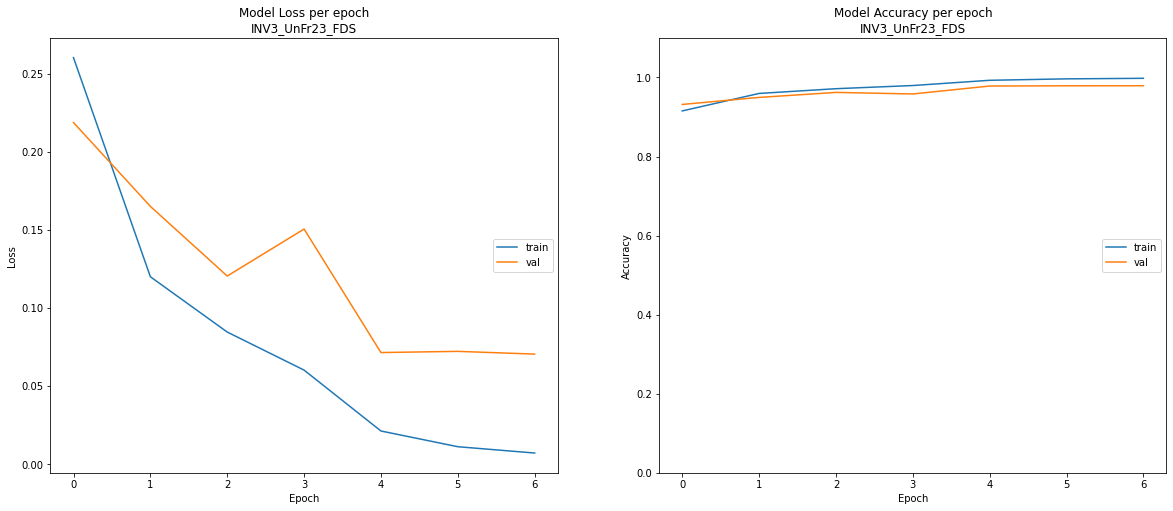

In [ ]:
graph(model_Inception_test_23_history,text_for_chart,)

In [ ]:
# save the model
model_Inception_test_23.save(model_save_dir+model_name_to_save)

###### Predictions and Analysis of Results

In [ ]:
### LOAD THE UNFREEZE MODEL ###
if 'model_Inception_test' in locals(): 
  del model_Inception_test
  
model_name_to_load = 'INV3_UnFr23_FDS.h5'
# load the model
model_Inception_test= keras.models.load_model(model_save_dir+model_name_to_load)

In [ ]:

print(model_Inception_test.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

In [ ]:
### Predictions ####

#Transform Dataset in TRANSFORM TEST DATASET IN NUMPY OBJECT #
import tensorflow_datasets as tfds
ds_numpy = tfds.as_numpy(test_gen_inception)

predictions_inception = np.array([])
labels_inception =  np.array([])


for x in ds_numpy:
  predictions_inception = np.concatenate([predictions_inception, np.argmax(model_Inception_test.predict(x[-2]), axis=-1)])
  labels_inception = np.concatenate([labels_inception, np.argmax(x[-1], axis=-1)])

In [ ]:
print(classification_report(labels_inception,   predictions_inception, digits = 3))

              precision    recall  f1-score   support

         0.0      0.990     0.986     0.988       504
         1.0      0.996     0.996     0.996       496
         2.0      0.993     0.998     0.995       440
         3.0      0.976     0.992     0.984       502
         4.0      0.993     0.987     0.990       454
         5.0      1.000     0.990     0.995       421
         6.0      0.996     0.991     0.993       456
         7.0      0.949     0.910     0.929       410
         8.0      0.998     0.990     0.994       477
         9.0      0.917     0.975     0.945       477
        10.0      1.000     0.989     0.995       465
        11.0      0.979     0.979     0.979       472
        12.0      0.981     0.979     0.980       480
        13.0      1.000     0.998     0.999       430
        14.0      1.000     1.000     1.000       423
        15.0      1.000     1.000     1.000       503
        16.0      1.000     0.987     0.993       459
        17.0      0.989    

In [ ]:
### Classification Report  ####

# If it's a loaded model leave third parameter empty (or set equal to None) 
classif_report(labels_inception,predictions_inception,) ## for loaded model
#classif_report(labels_inception,predictions_inception,model_history=model_history) ## for live trained model




              precision    recall  f1-score   support

         0.0      0.990     0.986     0.988       504
         1.0      0.996     0.996     0.996       496
         2.0      0.993     0.998     0.995       440
         3.0      0.976     0.992     0.984       502
         4.0      0.993     0.987     0.990       454
         5.0      1.000     0.990     0.995       421
         6.0      0.996     0.991     0.993       456
         7.0      0.949     0.910     0.929       410
         8.0      0.998     0.990     0.994       477
         9.0      0.917     0.975     0.945       477
        10.0      1.000     0.989     0.995       465
        11.0      0.979     0.979     0.979       472
        12.0      0.981     0.979     0.980       480
        13.0      1.000     0.998     0.999       430
        14.0      1.000     1.000     1.000       423
        15.0      1.000     1.000     1.000       503
        16.0      1.000     0.987     0.993       459
        17.0      0.989    

<Figure size 1440x360 with 0 Axes>

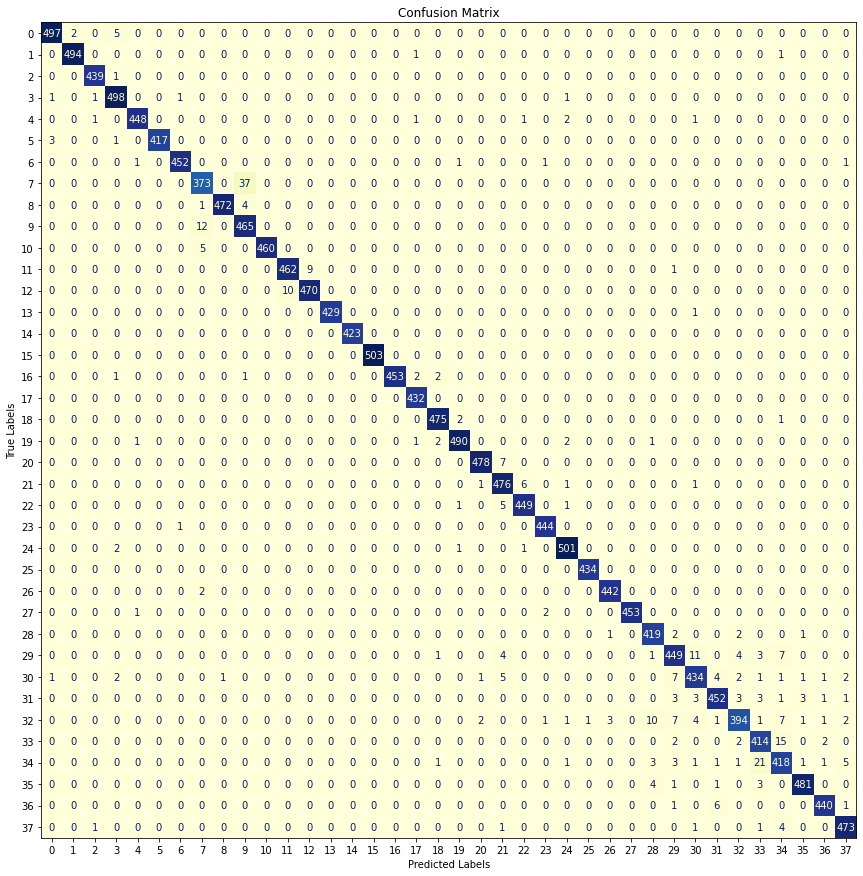

In [ ]:
  ### CONFUSION MATRIX ####
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
num_class = 38
conf_matrix(labels_inception,predictions_inception,num_class)

#### Conclusion


Unfreezing some layers increases the accuracy on the train set, but it also increases overfitting. So we can conclude that by taking into account the simulation time in unfreezed models, the Inception V3 is already quite balanced.